In [1]:
import numpy as np
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
import math 

In [2]:
from snowballstemmer import TurkishStemmer
from nltk.corpus import stopwords

In [3]:
import nltk 
#nltk.download('stopwords')
import re
def pre_process_words(words):
    ts=TurkishStemmer()
    words = [w.lower() for w in words if w.isalpha()]
    #burada noktalama işaretleri geri getirilebilir
    words = [ts.stemWord(w) for w in words if not w in set (stopwords.words('turkish'))]
    return words

In [4]:
def get_term_frequency_by_file(corpus):
    n_terms = {}
    n_terms_by_file = {}
    for file_id in corpus.fileids():
        # get words from the file
        words = corpus.words(file_id)
        # now do the cleaning, remove stop words, stemming, ....
        words = pre_process_words(words)
        for word in words:
            if word not in n_terms:
                n_terms[word] = 0
            n_terms[word] += 1
            #n_terms[word] = n_terms.get(word, 0) + 1
        n_terms_by_file[file_id] = n_terms
        n_terms = {}
    return n_terms_by_file

In [5]:
def unique_words(n_terms_by_file):
    unique_words = set()
    for n_terms in n_terms_by_file.values():
        for word in n_terms.keys():
            unique_words.add(word)
    return {word : index for index, word in zip(range(0, len(unique_words)), unique_words) }

In [6]:
def create_file_vectors(n_terms_by_file, unique_word_indexes):
    n_files = len(n_terms_by_file)
    n_unique_words = len(unique_word_indexes)
    word_vectors = np.zeros(shape=(n_files, n_unique_words))
    file_id_indexes = {file_id : index for index, file_id in zip(range(0, n_files), n_terms_by_file.keys()) }
    file_indexes_by_file_ids = {index : file_id for index, file_id in zip(range(0, n_files), n_terms_by_file.keys()) }
    for file_id, n_terms in n_terms_by_file.items():
        for word, freq in n_terms.items():
            file_index = file_id_indexes[file_id]
            word_vectors[file_index, unique_word_indexes[word]] = freq
    return word_vectors, file_id_indexes, file_indexes_by_file_ids

In [7]:
def get_idf(word_vectors, base):
    return np.log(word_vectors.shape[0] / np.sum(word_vectors != 0, axis=0)) / np.log(base)

In [8]:
def get_tf_idf(word_vectors, idf_by_term):
    return word_vectors * idf_by_term

In [9]:
def get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids):
    # hangi dosyalar negatif hangi dosyalar pozitif
    file_classes = {}
    n_pos = 0
    n_negs = 0
    for index, file_id in file_indexes_by_file_ids.items():
        if file_id.find('0_') > -1:
            file_classes[index] = 0 
            n_negs += 1 
        else:
            file_classes[index] = 1
            n_pos += 1
    
    TP = dict.fromkeys(unique_word_indexes.values(), 0)
    FP = dict.fromkeys(unique_word_indexes.values(), 0)
    FN = dict.fromkeys(unique_word_indexes.values(), 0)
    TN = dict.fromkeys(unique_word_indexes.values(), 0)

    for i in range(word_vectors.shape[1]):
        occurence_file_indexes = np.where(word_vectors[:, i] > 0)[0]
        for ofi in occurence_file_indexes:
            if file_classes[ofi] == 1:
                TP[i] += 1
            else:
                FP[i] += 1
        FN[i] = n_pos - TP[i]
        TN[i] = n_pos + n_negs - FN[i] - TP[i] - FP[i]
#         print(TN[i], FN[i])
#         FN[i] = 0
#         TN[i] = 0
#         occurence_file_indexes = np.where(word_vectors[:, i] == 0)[0]
#         for ofi in occurence_file_indexes:
#             if file_classes[ofi] == 1:
#                 FN[i] += 1
#             else:
#                 TN[i] += 1
#         print(' ', TN[i], FN[i])
    #tpler üzerinde gezerrek fn hesapla
    return TP, FP, FN, TN, file_classes
    

In [10]:
def get_supervised_tw(TP, FP, FN, TN, file_classes, method = 'chi2'):
    N = len(file_classes)
    weightings = [0] * (len(TP))
    for i in range(len(TP)):
        if method == 'chi2':
            dividend = ( (TP[i] * TN[i]) - (FP[i] * FN[i]))**2 
            divisor  = ( (TP[i] + FN[i]) * (FP[i] + TN[i]) * (TP[i] + FP[i]) * (FN[i] + TN[i]))
        #chi_square[i]=N*((((TP[i]*TN[i])-(FP[i]*FN[i]))**2)/((TP[i]+FN[i])*(FP[i]+TN[i])*(TP[i]+FP[i])*(FN[i]+TN[i])))
            weightings[i]= N * dividend / divisor
        elif method == 'or': 
            dividend = TP[i] * TN[i]   
            divisor  = FP[i] * FN[i]
        #chi_square[i]=N*((((TP[i]*TN[i])-(FP[i]*FN[i]))**2)/((TP[i]+FN[i])*(FP[i]+TN[i])*(TP[i]+FP[i])*(FN[i]+TN[i])))
            weightings[i]= math.log( (dividend+.005) / (2*.005+divisor), 2)
        elif method == 'ig':
            if (((TP[i]+FP[i])/N)+(TP[i]/N)) >0 and ((TP[i]/(TP[i]+FN[i]))+(FP[i]/N)) > 0 and (FP[i]/(FP[i]+TN[i]))>0:
                weightings[i]= (-((TP[i]+FP[i])/N))*(math.log((((TP[i]+FP[i])/N)+(TP[i]/N)),2))*(math.log((TP[i]/(TP[i]+FN[i]))+(FP[i]/N),2))*(math.log((FP[i]/(FP[i]+TN[i])),2))
            else:
                weightings[i]=0
        elif method == 'mi':
            if ((TP[i]*N)/((TP[i]+FP[i])*(TP[i]+FN[i])))>0:
                weightings[i] = math.log(((TP[i]*N)/((TP[i]+FP[i])*(TP[i]+FN[i]))),2)
            else:
                weightings[i]=0
    return weightings

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sbn
def plot_confusion_matrix(Y_test,Y_pred):
    result =confusion_matrix(np.squeeze(Y_test),np.squeeze(Y_pred))
    plt.title('Confusion matrix')
    sbn.heatmap(result, cmap=plt.cm.Blues,annot=True , fmt="d")
    plt.ylabel('Beklenen Değer')
    plt.xlabel('Tahmin Edilen Değer')

In [12]:
def plot_roc_curve(Y_test,  Y_pred):
    fpr, tpr, thresholds  = metrics.roc_curve(Y_test,  Y_pred)
    auc = metrics.roc_auc_score(Y_test, Y_pred)
    plt.plot(fpr,tpr,label="ROC Curve (AUC="+str(auc)+")", color='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Yanlış Pozitif Oran')
    plt.ylabel('Doğru Pozitif Oran')
    plt.title('ROC EĞRİSİ')
    plt.legend()
    plt.show()
    plt.figure(figsize=(7, 5))
    print(fpr,tpr, auc)

n_terms_by_file = get_term_frequency_by_file(corpus)
unique_word_indexes = unique_words(n_terms_by_file)
# get TF matrix
word_vectors,  file_id_indexes, file_indexes_by_file_ids = create_file_vectors(n_terms_by_file, unique_word_indexes)

#chi_square_term_weight=word_vectors*chi_square

# idf hesapla
idf_by_term = get_idf(word_vectors, 2)

# tf-idf matrixi oluştur
word_vectors = get_tf_idf(word_vectors, idf_by_term)
#öğrenme tamamla TF-IDF TAMAMLAMA

TP, FP, FN, TN, file_classes = get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids)


chi_square = get_chi_square(TP, FP, FN, TN, file_classes)

In [13]:
def my_test(method):
    corpus = CategorizedPlaintextCorpusReader(r'C:\Users\almil\Desktop\projeler\bitirme tezi\Untitled Folder\deneme1', r'.*\.*', cat_pattern=r'(.*)/')
    n_terms_by_file = get_term_frequency_by_file(corpus)
    unique_word_indexes = unique_words(n_terms_by_file)
    # get TF matrix
    word_vectors,  file_id_indexes, file_indexes_by_file_ids = create_file_vectors(n_terms_by_file, unique_word_indexes)
    TP, FP, FN, TN, file_classes = get_contingency_matrix(word_vectors, unique_word_indexes, file_indexes_by_file_ids)

    
    #chi_square_term_weight=word_vectors*chi_square
    if method == 'idf':
        # idf hesapla
        idf_by_term = get_idf(word_vectors, 2)

        # tf-idf matrixi oluştur
        word_vectors = get_tf_idf(word_vectors, idf_by_term)
    #öğrenme tamamla TF-IDF TAMAMLAMA
    elif method == 'chi2':
        chi_square = get_supervised_tw(TP, FP, FN, TN, file_classes, 'chi2')
        word_vectors = word_vectors * chi_square
    elif method == 'or':
        odds_ratio = get_supervised_tw(TP, FP, FN, TN, file_classes, 'or')
        word_vectors = word_vectors * odds_ratio
    elif method == 'ig':
        information_gain = get_supervised_tw(TP, FP, FN, TN, file_classes, 'ig')
        word_vectors = word_vectors * information_gain
    elif method == 'mi':
        mutual_information = get_supervised_tw(TP, FP, FN, TN, file_classes, 'mi')
        word_vectors = word_vectors * mutual_information
    return word_vectors, file_classes 

In [14]:
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
k_result_dic={"fbeta" : [], "precision" : [], "recall" : [], "accuracy" : [], "y_test" : [], "y_pred": []}
def machineLearning(machineLearningName):
    
    listml=[]
    skf = StratifiedKFold(n_splits=10, random_state = 1, shuffle = True)
    for train_index, test_index in skf.split(X, Y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        if machineLearningName == "RandomForestClassifier":
            rfc=RandomForestClassifier()
            rfc_m=rfc.fit(X_train,y_train)
            Y_pred=rfc.predict(X_test)
        elif machineLearningName == "LogisticRegression":
            lr = LogisticRegression(max_iter=3000)
            lr_m = lr.fit(X_train, y_train)
            Y_pred = lr.predict(X_test)
        elif machineLearningName == "GaussianNB":
            gnb=GaussianNB()
            gnb_m=gnb.fit(X_train, y_train)
            Y_pred=gnb.predict(X_test)
        
        #print(metrics.fbeta_score(y_test, Y_pred, beta = 2))
        #print(metrics.fbeta_score(y_test, Y_pred, beta = .5))
        #print(metrics.precision_score(y_test, Y_pred))
        #print(metrics.recall_score(y_test, Y_pred))
        #print(metrics.accuracy_score(y_test, Y_pred))
        plot_confusion_matrix(y_test, Y_pred)
        plt.show()
        k_result_dic["fbeta"].append(metrics.fbeta_score(y_test, Y_pred, beta = 1))
        k_result_dic["precision"].append( metrics.precision_score(y_test, Y_pred))
        k_result_dic["recall"].append(metrics.recall_score(y_test, Y_pred))
        k_result_dic["accuracy"].append(metrics.accuracy_score(y_test, Y_pred))
        k_result_dic["y_test"].append(y_test)
        k_result_dic["y_pred"].append( Y_pred)
        #listml.append([metrics.fbeta_score(y_test, Y_pred, beta = 1), metrics.precision_score(y_test, Y_pred), metrics.recall_score(y_test, Y_pred), metrics.accuracy_score(y_test, Y_pred), y_test, Y_pred])
        #print(listml)
    print (k_result_dic)
    

In [15]:
import statistics
def find_median(k_result_dic):
    list_dnm=k_result_dic["fbeta"]
    list_dnm.sort()
    indexformedian=k_result_dic["fbeta"].index(list_dnm[5])
    


idf
GaussianNB


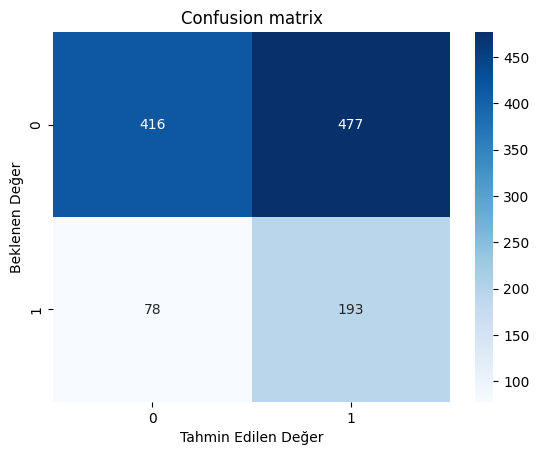

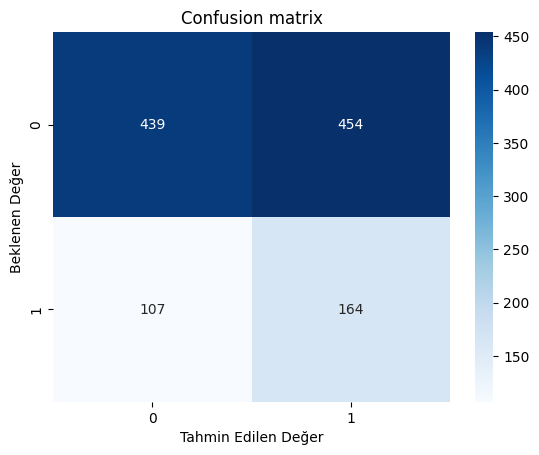

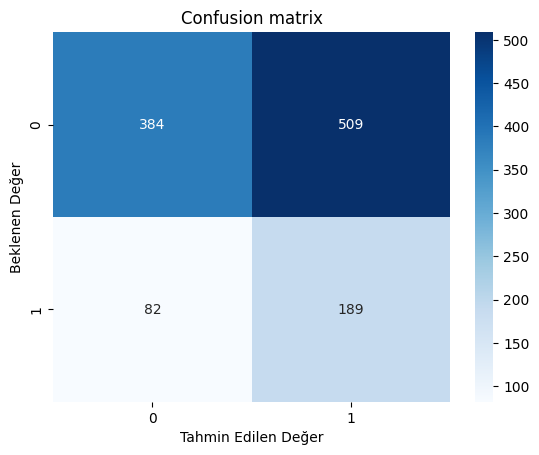

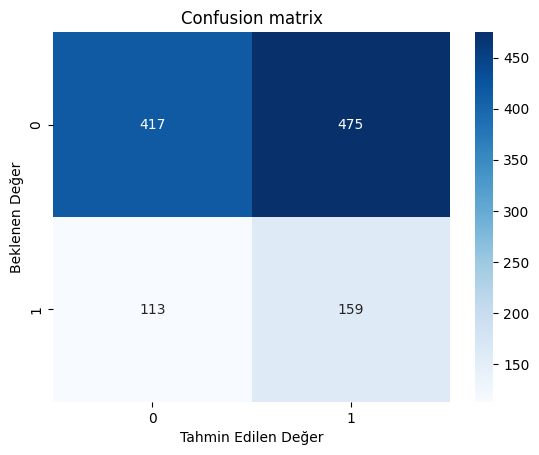

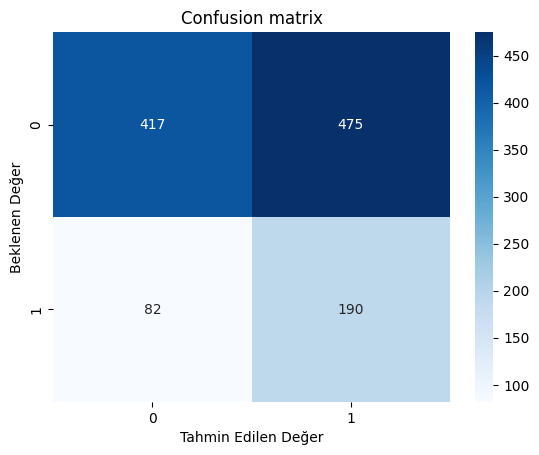

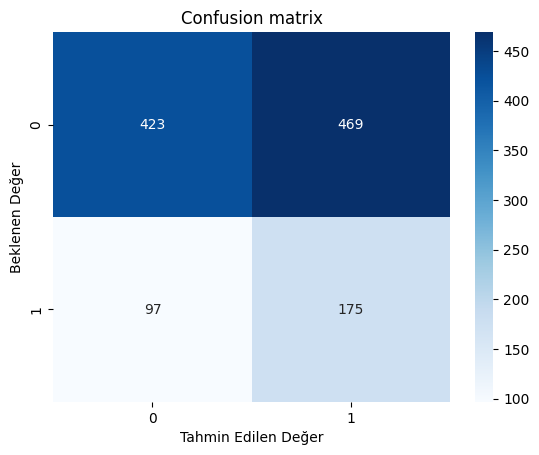

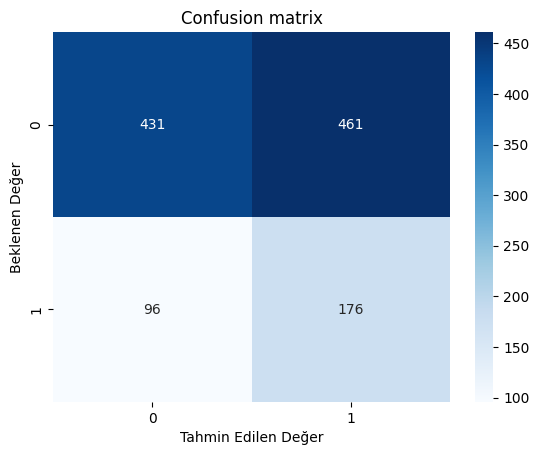

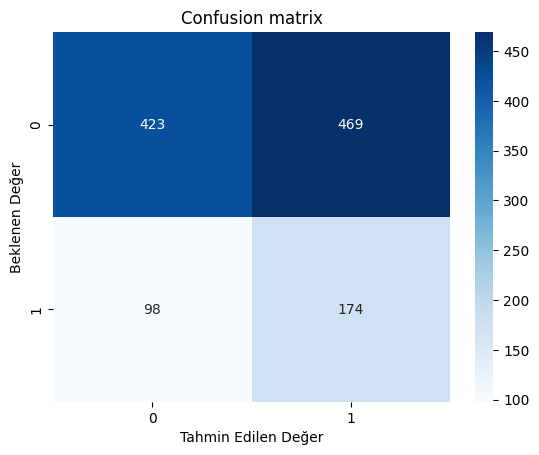

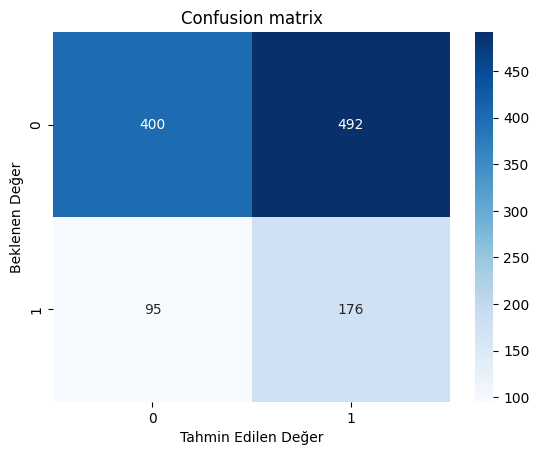

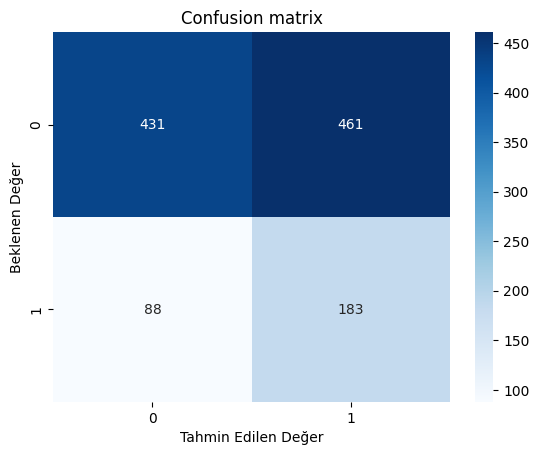

{'fbeta': [0.410201912858661, 0.36895388076490443, 0.39009287925696595, 0.3509933774834437, 0.4055496264674493, 0.3820960698689956, 0.3872387238723872, 0.380327868852459, 0.37486687965921195, 0.39999999999999997], 'precision': [0.2880597014925373, 0.26537216828478966, 0.2707736389684814, 0.250788643533123, 0.2857142857142857, 0.2717391304347826, 0.27629513343799056, 0.27060653188180406, 0.2634730538922156, 0.2841614906832298], 'recall': [0.7121771217712177, 0.6051660516605166, 0.6974169741697417, 0.5845588235294118, 0.6985294117647058, 0.6433823529411765, 0.6470588235294118, 0.6397058823529411, 0.6494464944649446, 0.6752767527675276], 'accuracy': [0.5231958762886598, 0.5180412371134021, 0.49226804123711343, 0.4948453608247423, 0.5214776632302406, 0.5137457044673539, 0.5214776632302406, 0.5128865979381443, 0.49527085124677556, 0.5279449699054171], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), ar

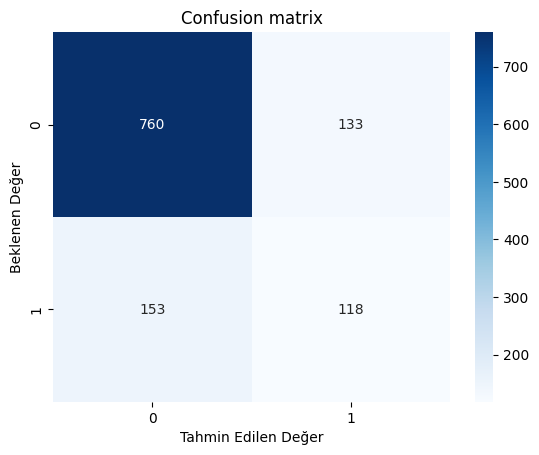

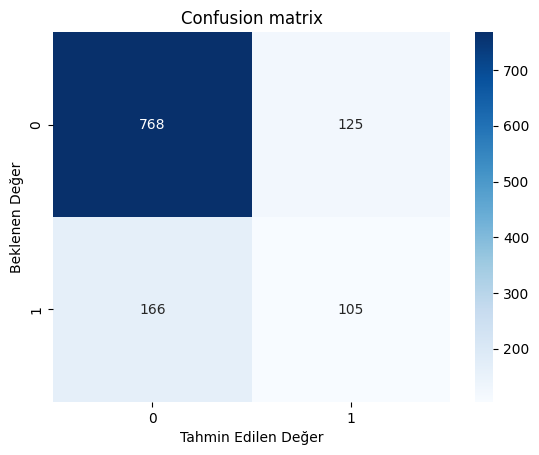

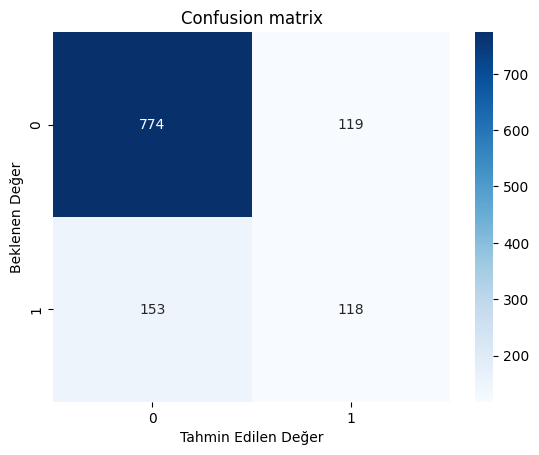

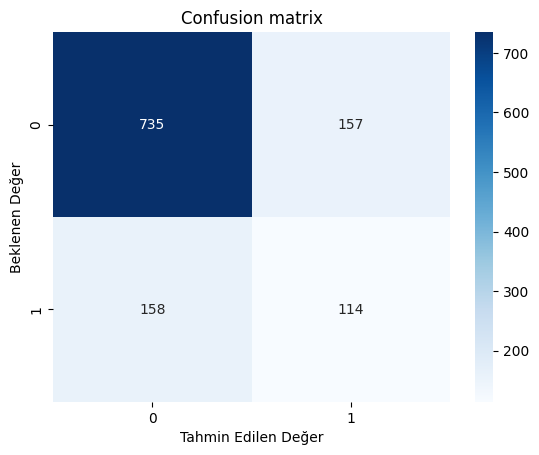

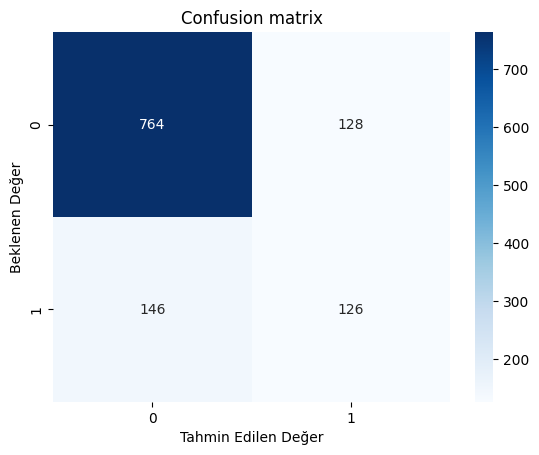

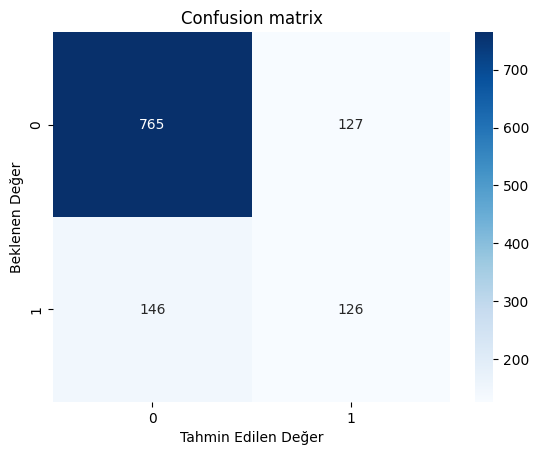

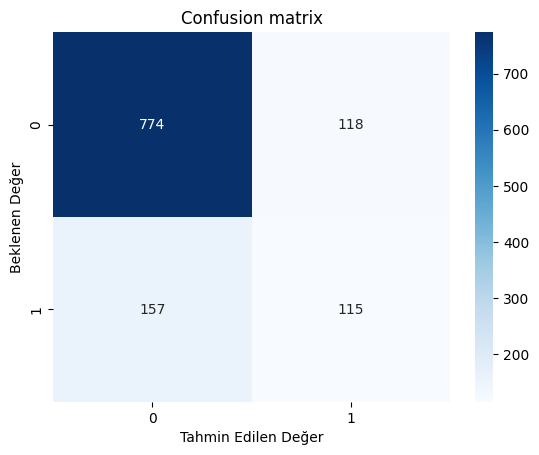

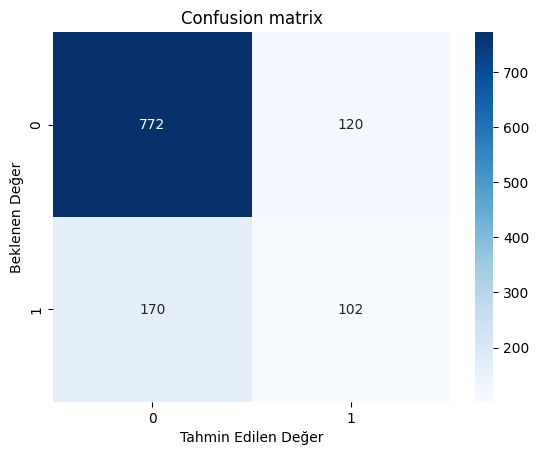

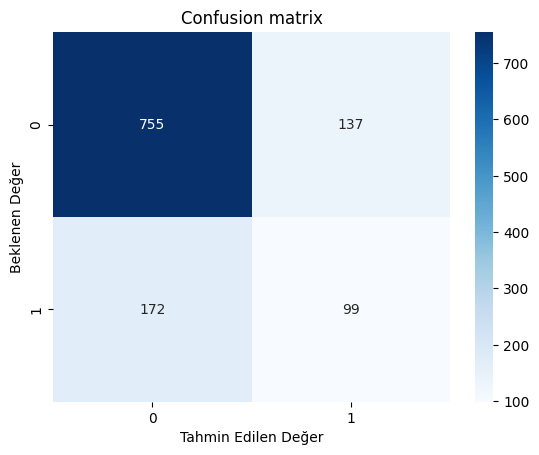

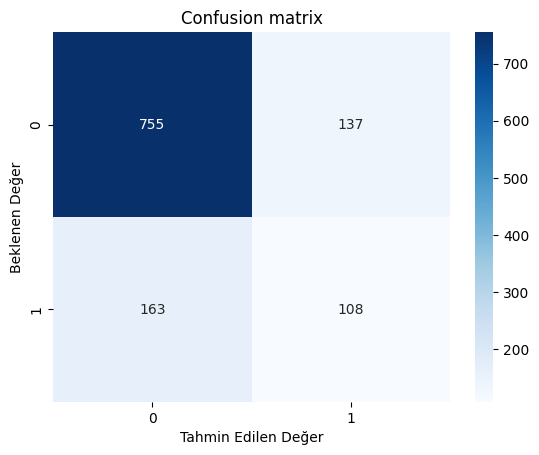

{'fbeta': [0.4521072796934866, 0.4191616766467066, 0.4645669291338583, 0.4198895027624309, 0.47908745247148293, 0.48, 0.4554455445544554, 0.4129554655870446, 0.3905325443786983, 0.4186046511627907], 'precision': [0.4701195219123506, 0.45652173913043476, 0.4978902953586498, 0.42066420664206644, 0.49606299212598426, 0.4980237154150198, 0.49356223175965663, 0.4594594594594595, 0.4194915254237288, 0.44081632653061226], 'recall': [0.4354243542435424, 0.3874538745387454, 0.4354243542435424, 0.41911764705882354, 0.4632352941176471, 0.4632352941176471, 0.4227941176470588, 0.375, 0.36531365313653136, 0.3985239852398524], 'accuracy': [0.7542955326460481, 0.75, 0.7663230240549829, 0.729381443298969, 0.7646048109965635, 0.7654639175257731, 0.7637457044673539, 0.7508591065292096, 0.7343078245915735, 0.7420464316423044], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 

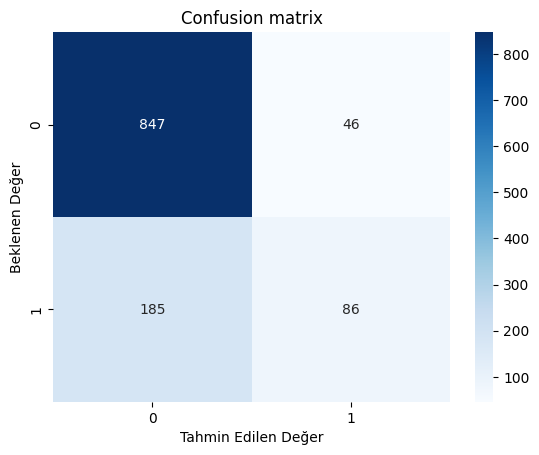

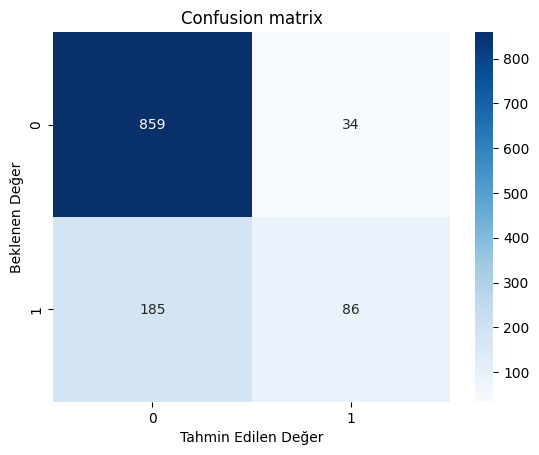

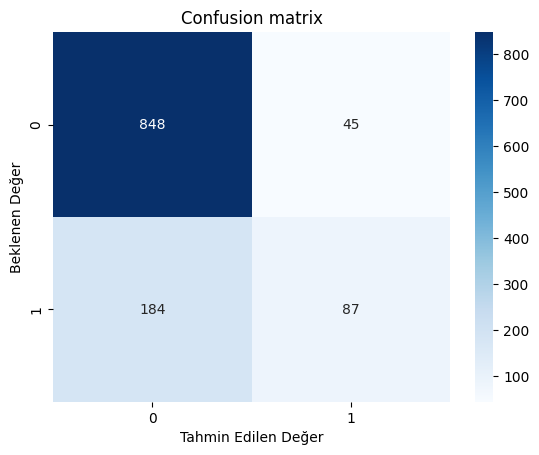

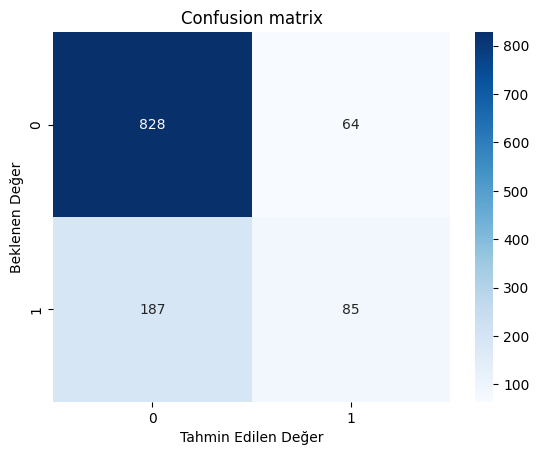

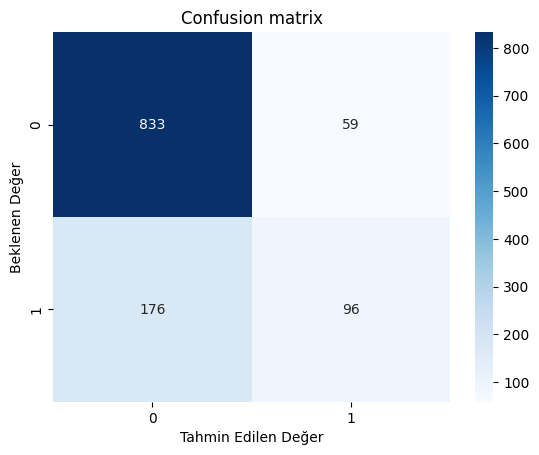

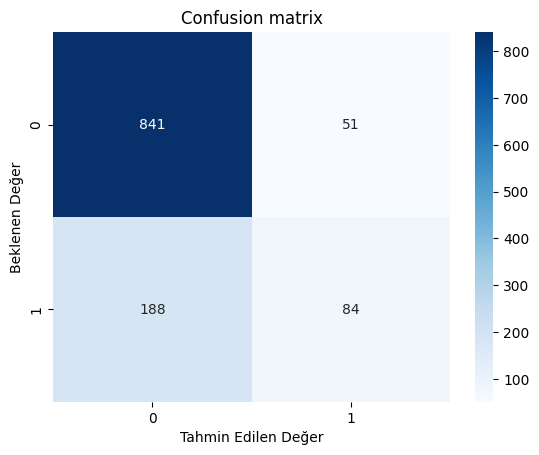

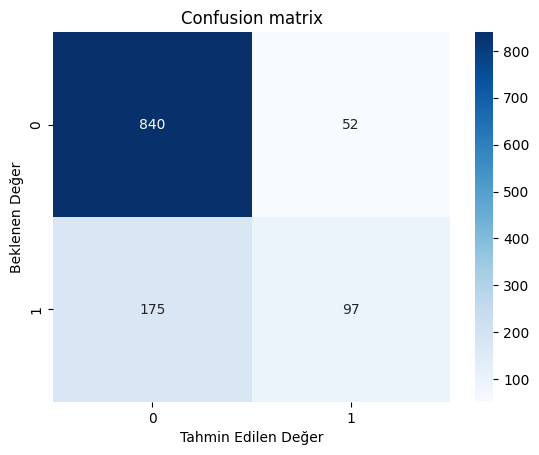

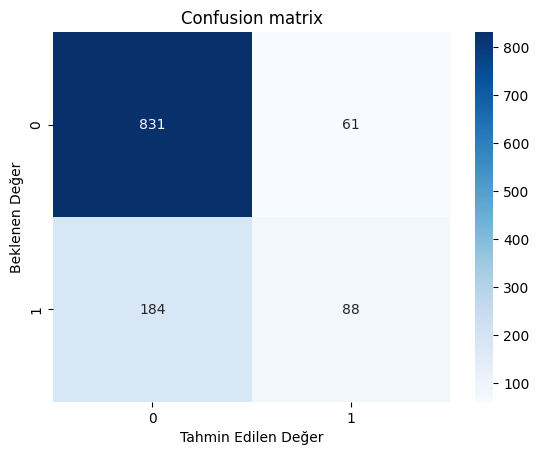

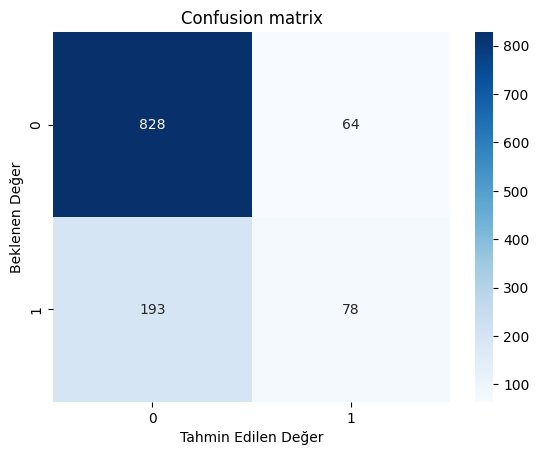

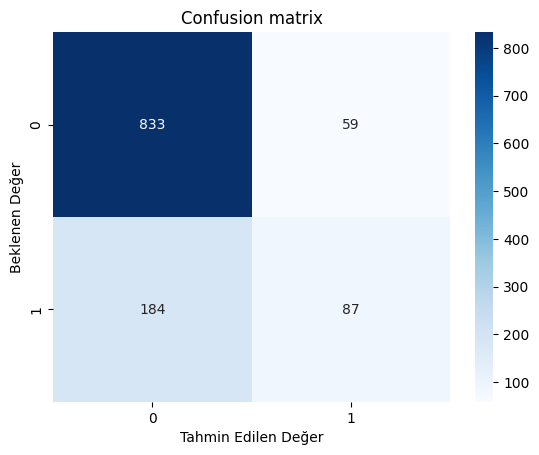

{'fbeta': [0.4267990074441687, 0.4398976982097186, 0.43176178660049624, 0.4038004750593824, 0.4496487119437939, 0.4127764127764128, 0.46080760095011875, 0.41805225653206657, 0.37772397094431, 0.4172661870503597], 'precision': [0.6515151515151515, 0.7166666666666667, 0.6590909090909091, 0.5704697986577181, 0.6193548387096774, 0.6222222222222222, 0.6510067114093959, 0.5906040268456376, 0.5492957746478874, 0.5958904109589042], 'recall': [0.3173431734317343, 0.3173431734317343, 0.3210332103321033, 0.3125, 0.35294117647058826, 0.3088235294117647, 0.35661764705882354, 0.3235294117647059, 0.2878228782287823, 0.3210332103321033], 'accuracy': [0.8015463917525774, 0.8118556701030928, 0.8032646048109966, 0.7843642611683849, 0.7981099656357389, 0.7946735395189003, 0.8049828178694158, 0.7895189003436426, 0.7790197764402408, 0.7910576096302665], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, .

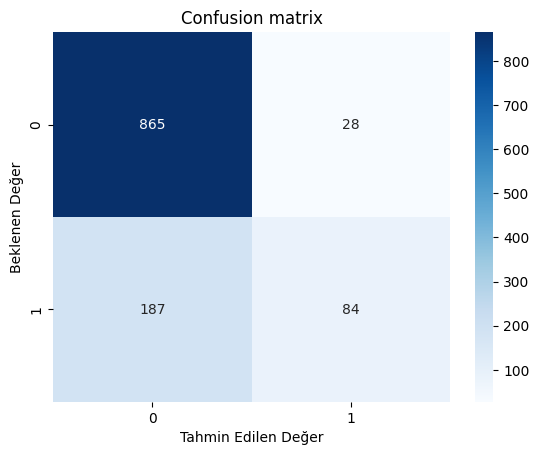

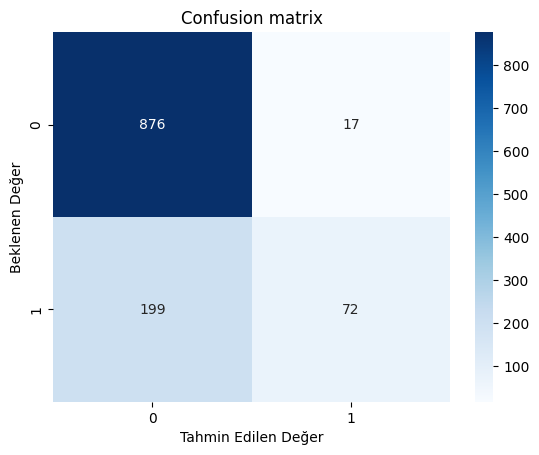

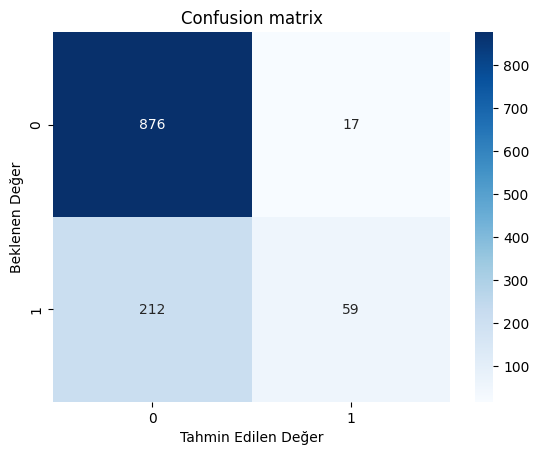

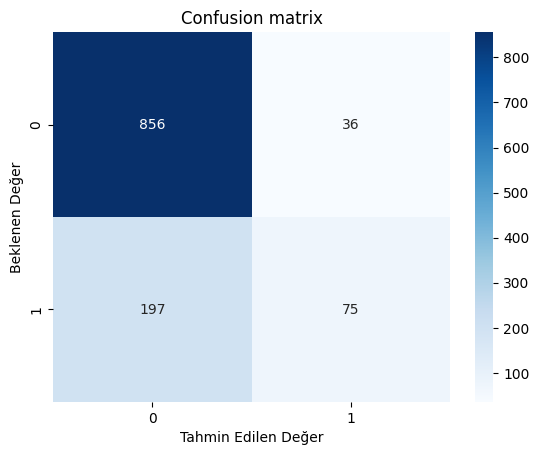

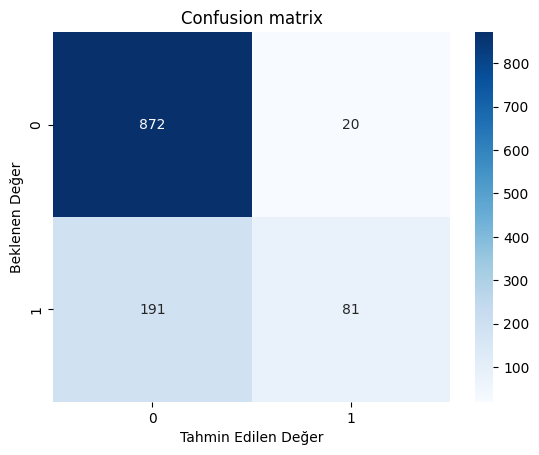

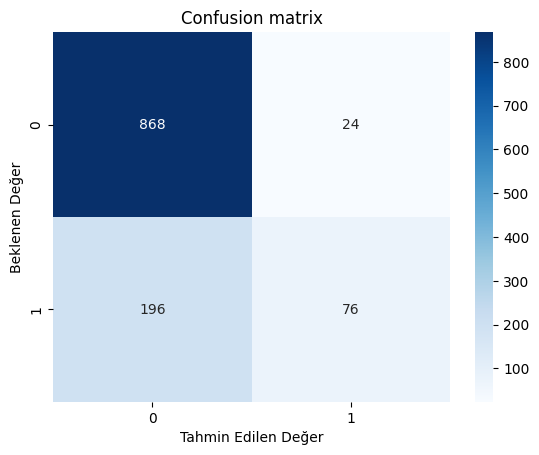

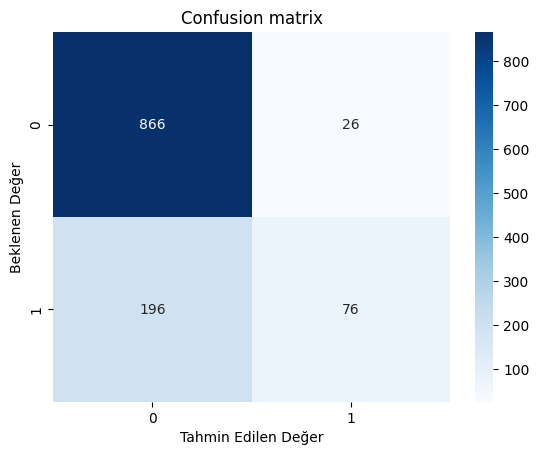

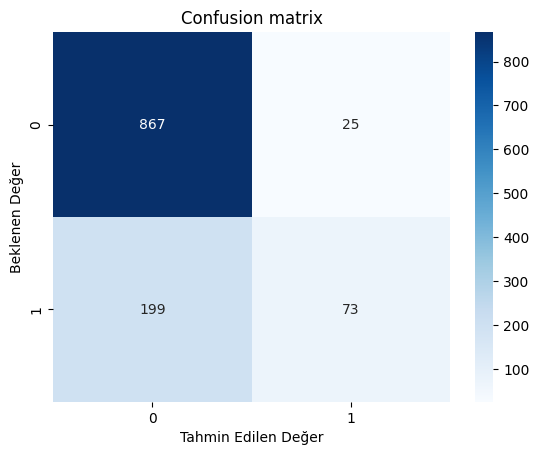

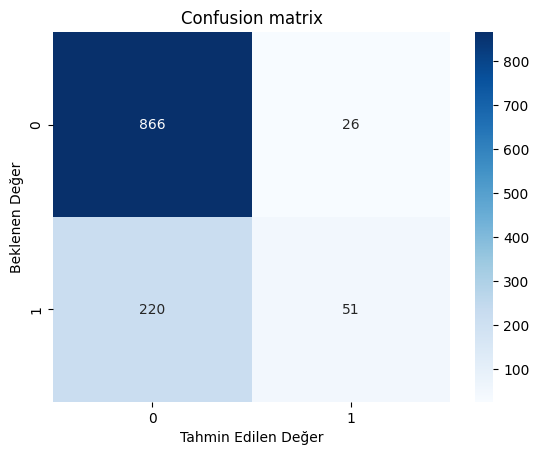

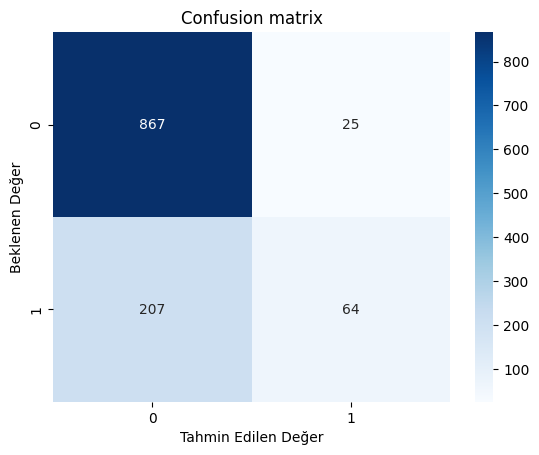

{'fbeta': [0.4386422976501306, 0.4, 0.34005763688760804, 0.391644908616188, 0.4343163538873994, 0.4086021505376344, 0.4064171122994653, 0.3945945945945946, 0.29310344827586204, 0.3555555555555555], 'precision': [0.75, 0.8089887640449438, 0.7763157894736842, 0.6756756756756757, 0.801980198019802, 0.76, 0.7450980392156863, 0.7448979591836735, 0.6623376623376623, 0.7191011235955056], 'recall': [0.30996309963099633, 0.2656826568265683, 0.2177121771217712, 0.2757352941176471, 0.2977941176470588, 0.27941176470588236, 0.27941176470588236, 0.26838235294117646, 0.1881918819188192, 0.23616236162361623], 'accuracy': [0.8152920962199313, 0.8144329896907216, 0.8032646048109966, 0.7998281786941581, 0.8187285223367697, 0.8109965635738832, 0.8092783505154639, 0.8075601374570447, 0.7884780739466896, 0.8005159071367154], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0

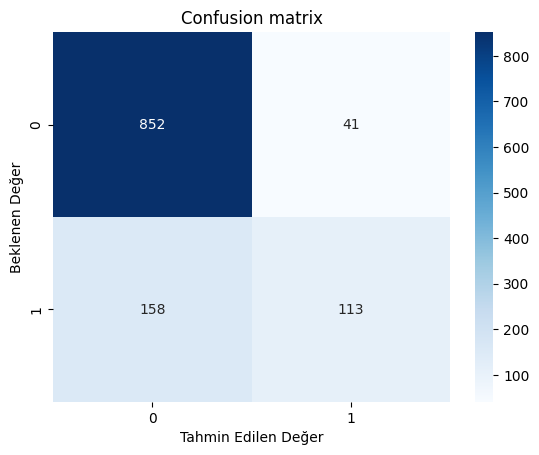

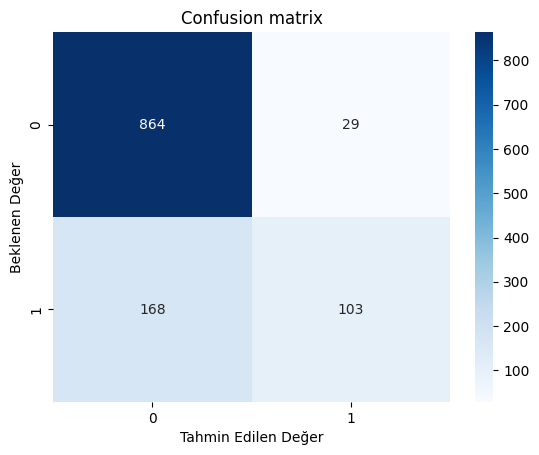

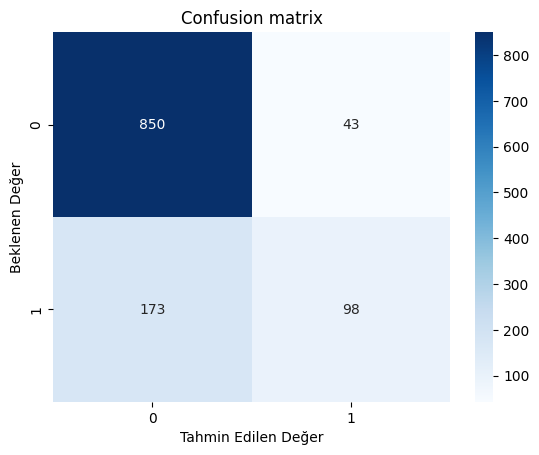

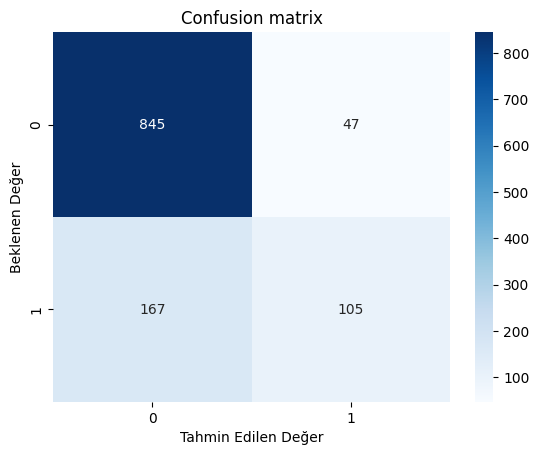

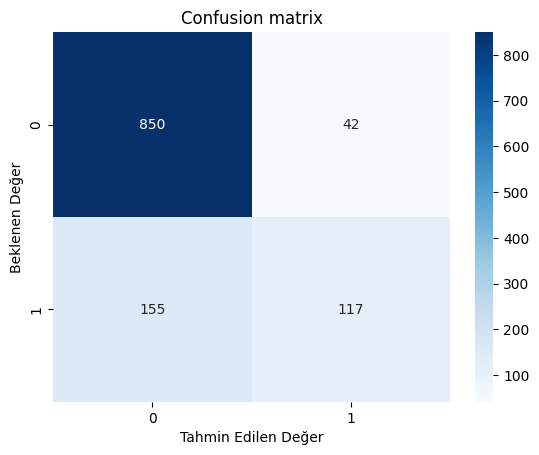

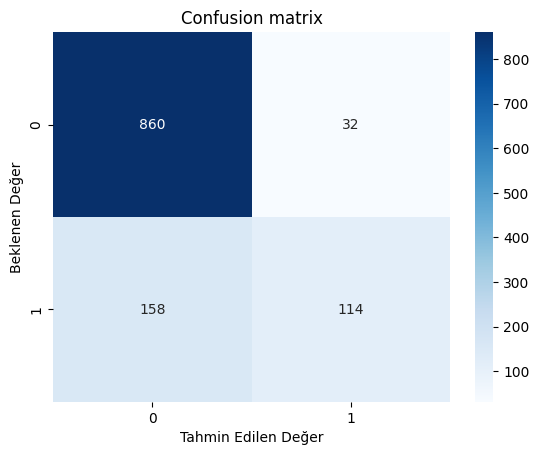

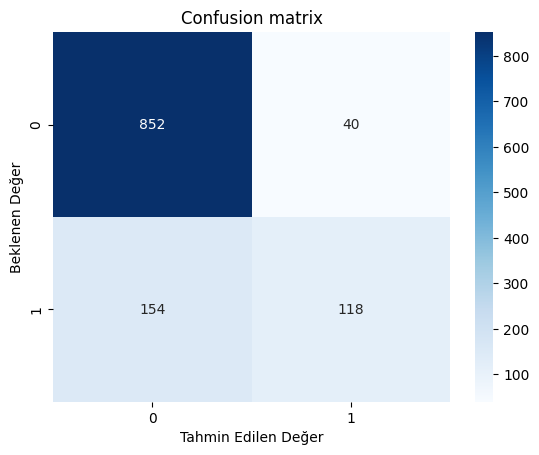

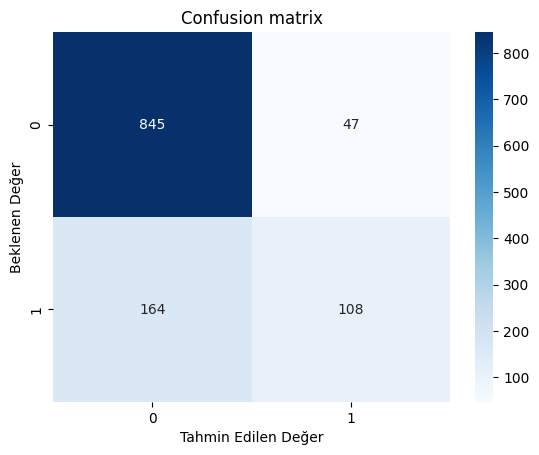

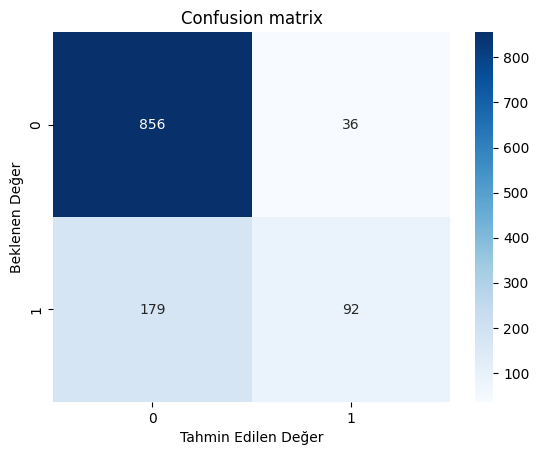

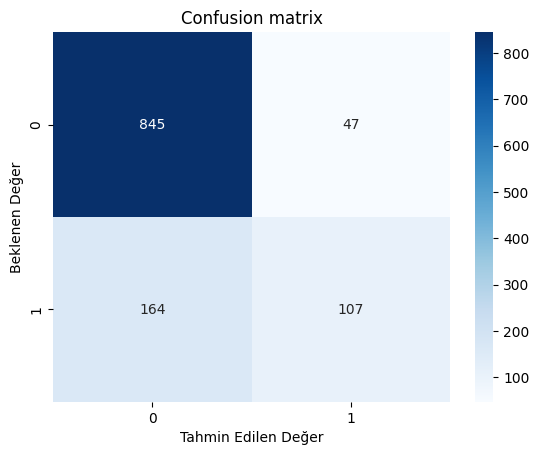

{'fbeta': [0.5317647058823529, 0.511166253101737, 0.47572815533980584, 0.4952830188679245, 0.5429234338747099, 0.5454545454545455, 0.5488372093023256, 0.5058548009367682, 0.46115288220551376, 0.5035294117647058], 'precision': [0.7337662337662337, 0.7803030303030303, 0.6950354609929078, 0.6907894736842105, 0.7358490566037735, 0.7808219178082192, 0.7468354430379747, 0.6967741935483871, 0.71875, 0.6948051948051948], 'recall': [0.41697416974169743, 0.3800738007380074, 0.36162361623616235, 0.3860294117647059, 0.43014705882352944, 0.41911764705882354, 0.4338235294117647, 0.39705882352941174, 0.33948339483394835, 0.3948339483394834], 'accuracy': [0.8290378006872853, 0.8307560137457045, 0.8144329896907216, 0.8161512027491409, 0.8307560137457045, 0.8367697594501718, 0.8333333333333334, 0.8187285223367697, 0.8151332760103182, 0.8185726569217541], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0,

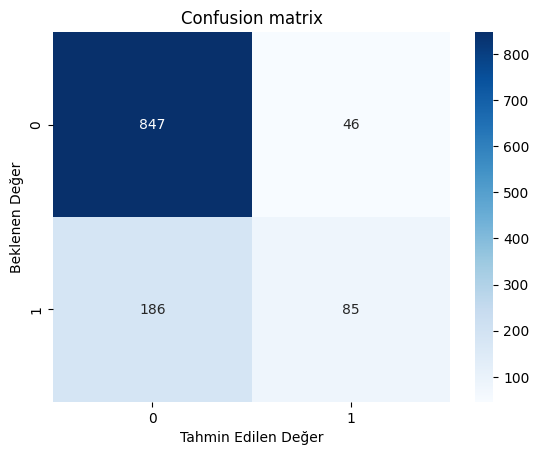

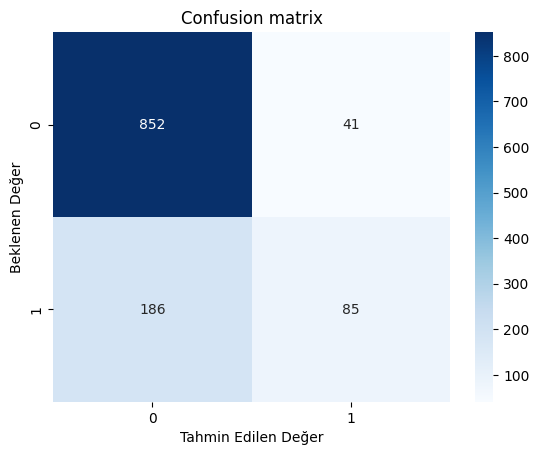

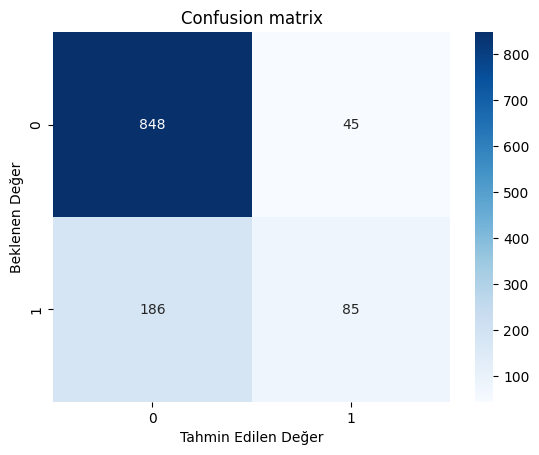

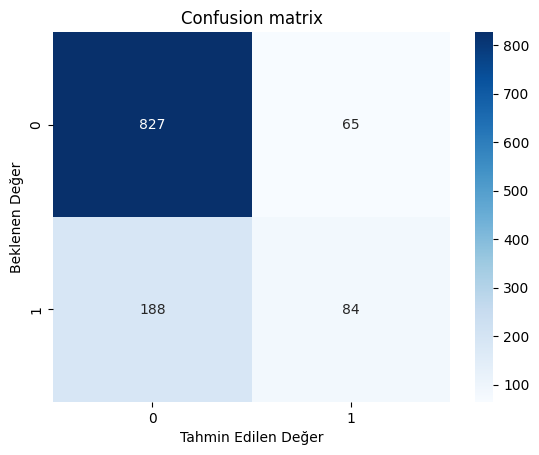

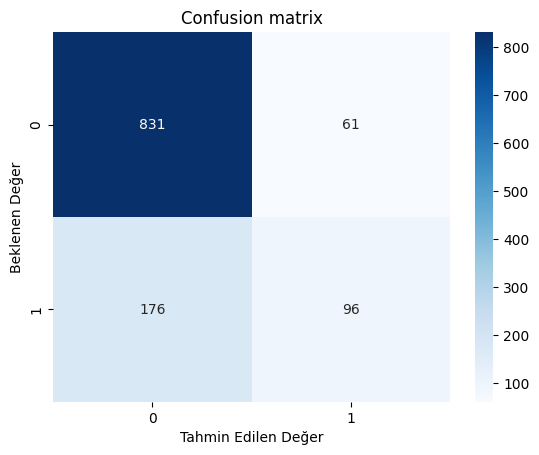

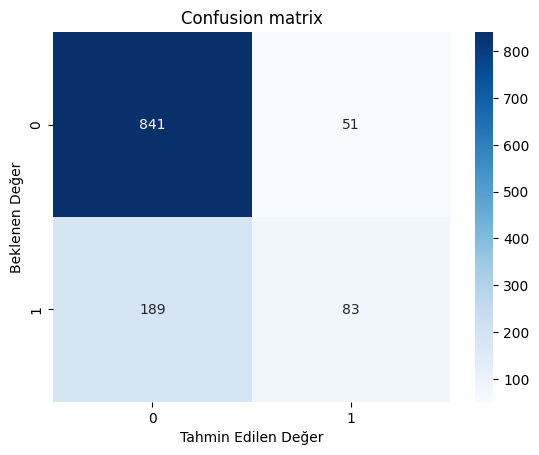

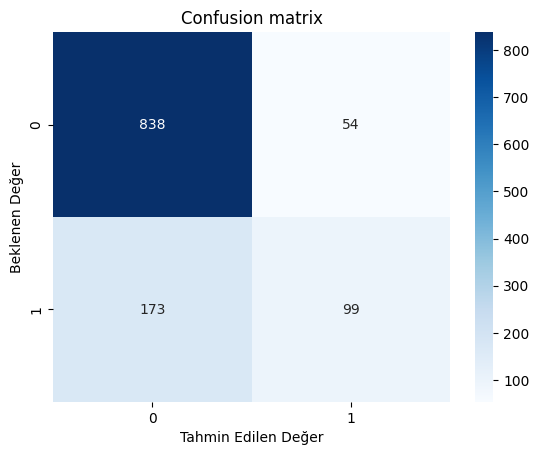

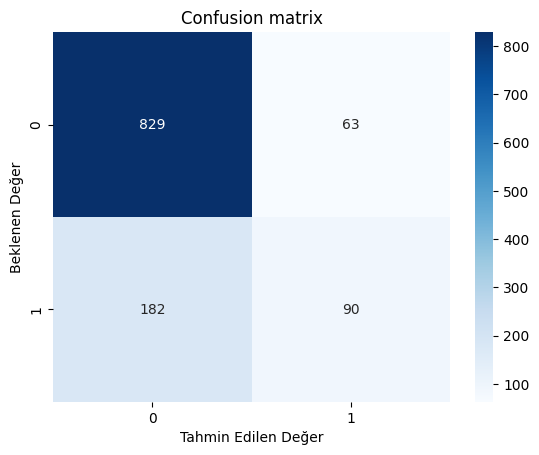

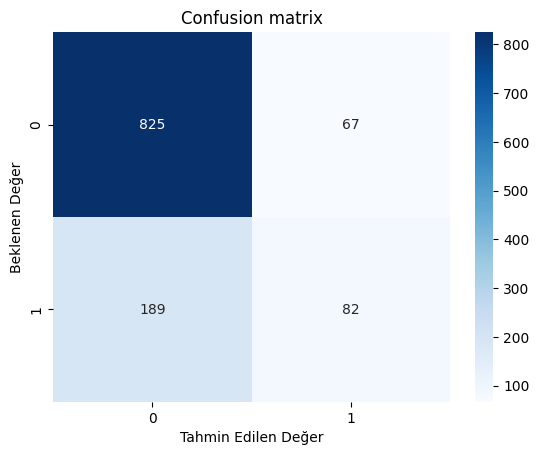

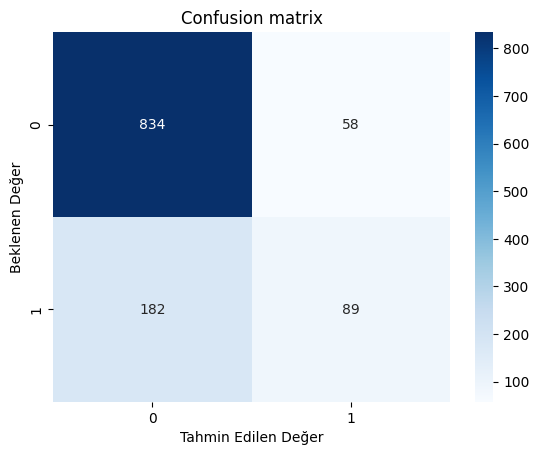

{'fbeta': [0.4228855721393035, 0.4282115869017633, 0.4239401496259352, 0.3990498812351544, 0.44755244755244755, 0.4088669950738916, 0.4658823529411765, 0.4235294117647059, 0.3904761904761905, 0.4258373205741627], 'precision': [0.648854961832061, 0.6746031746031746, 0.6538461538461539, 0.5637583892617449, 0.6114649681528662, 0.6194029850746269, 0.6470588235294118, 0.5882352941176471, 0.5503355704697986, 0.6054421768707483], 'recall': [0.31365313653136534, 0.31365313653136534, 0.31365313653136534, 0.3088235294117647, 0.35294117647058826, 0.30514705882352944, 0.3639705882352941, 0.33088235294117646, 0.3025830258302583, 0.3284132841328413], 'accuracy': [0.8006872852233677, 0.8049828178694158, 0.8015463917525774, 0.7826460481099656, 0.7963917525773195, 0.7938144329896907, 0.8049828178694158, 0.7895189003436426, 0.7798796216680998, 0.7936371453138436], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), ar

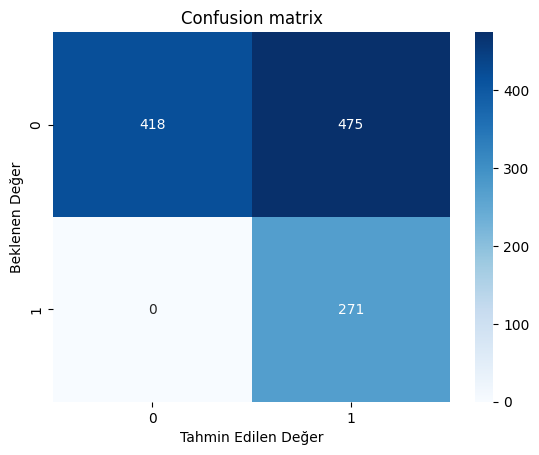

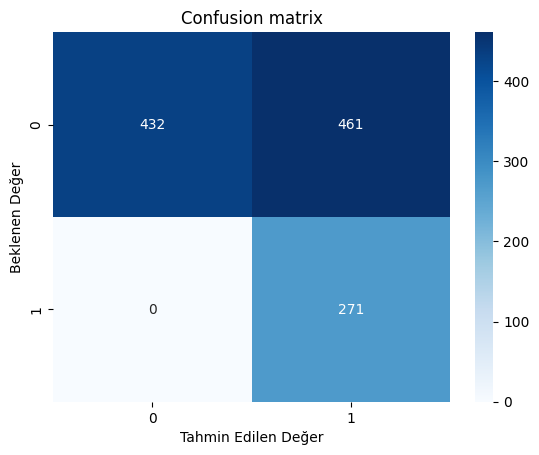

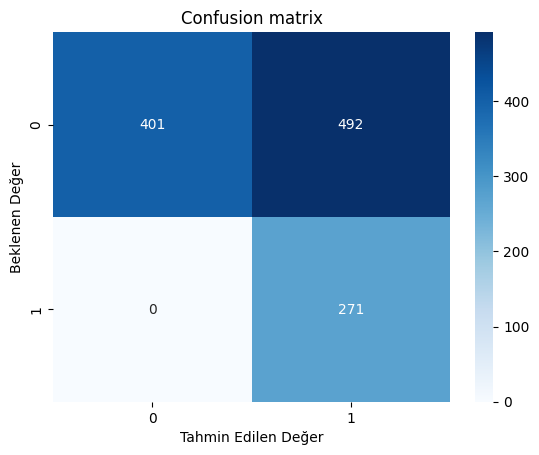

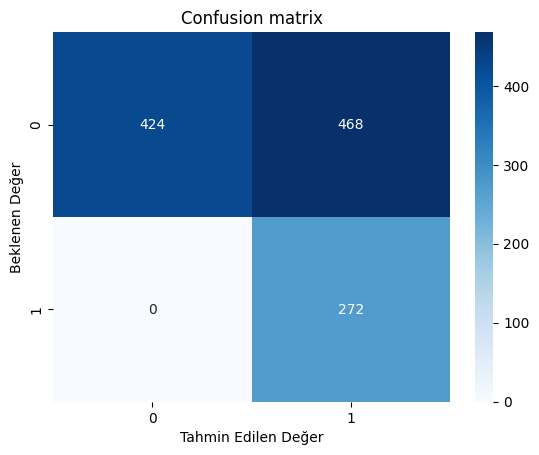

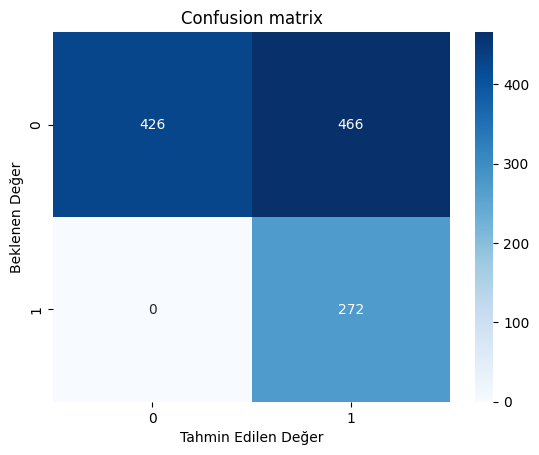

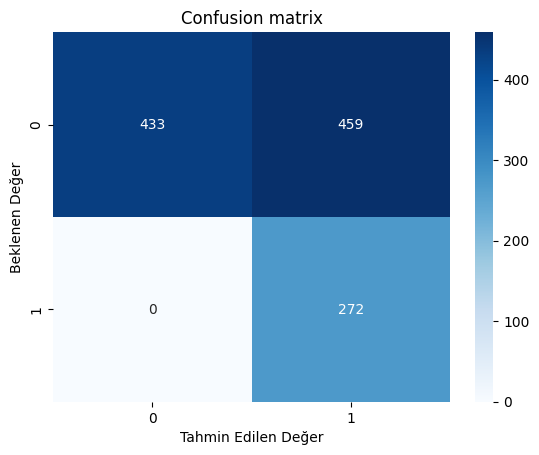

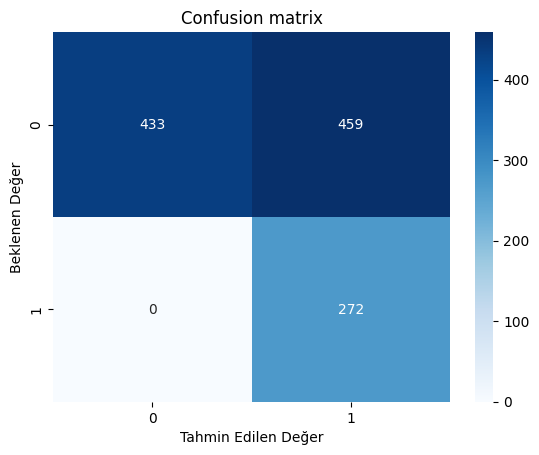

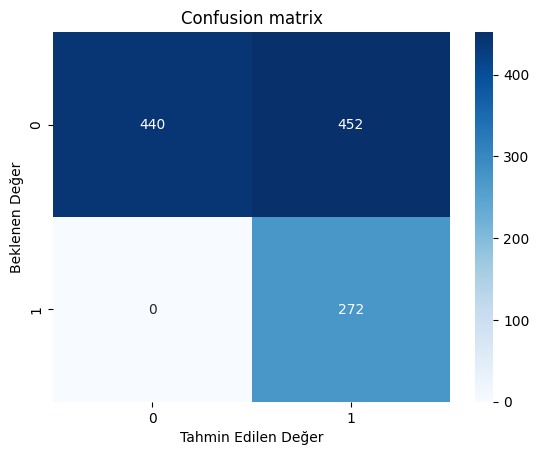

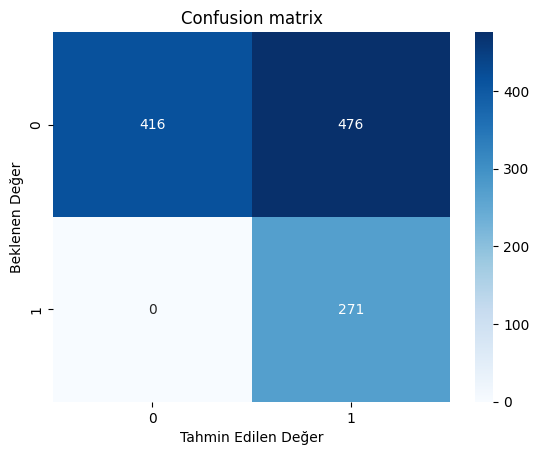

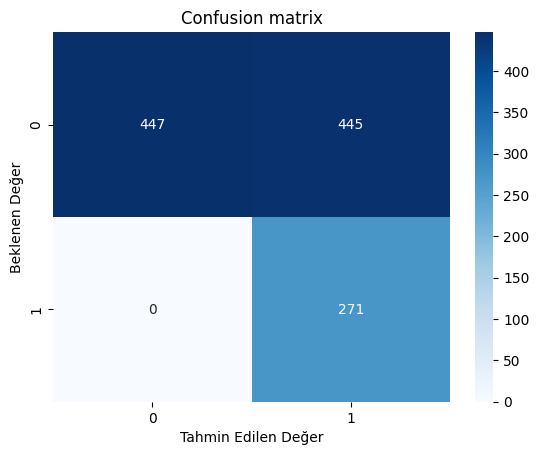

{'fbeta': [0.5329400196656834, 0.5403788634097707, 0.5241779497098646, 0.5375494071146245, 0.5386138613861386, 0.5423728813559322, 0.5423728813559322, 0.5461847389558233, 0.5324165029469549, 0.5491388044579534], 'precision': [0.3632707774798928, 0.3702185792349727, 0.35517693315858456, 0.3675675675675676, 0.3685636856368564, 0.37209302325581395, 0.37209302325581395, 0.3756906077348066, 0.3627844712182062, 0.3784916201117318], 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'accuracy': [0.5919243986254296, 0.6039518900343642, 0.5773195876288659, 0.5979381443298969, 0.5996563573883161, 0.6056701030927835, 0.6056701030927835, 0.6116838487972509, 0.5907136715391229, 0.6173688736027515], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 

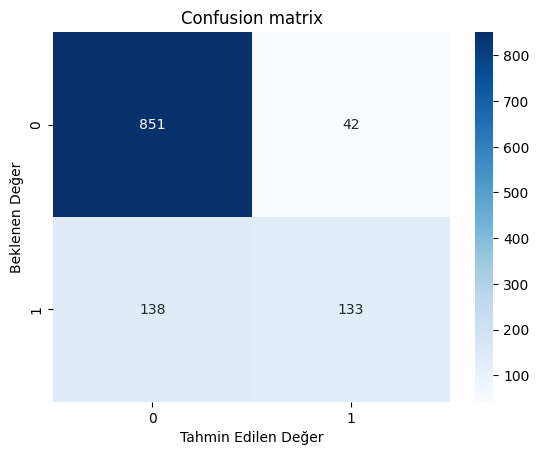

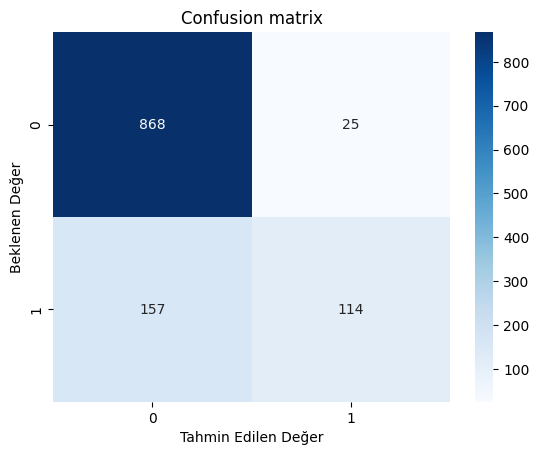

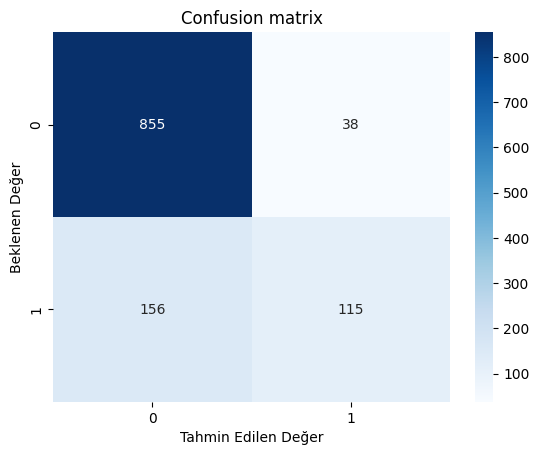

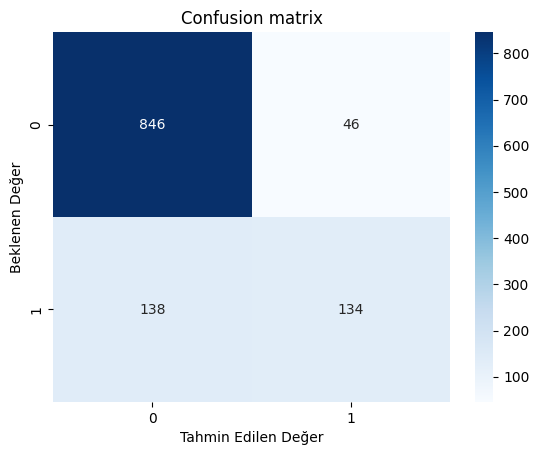

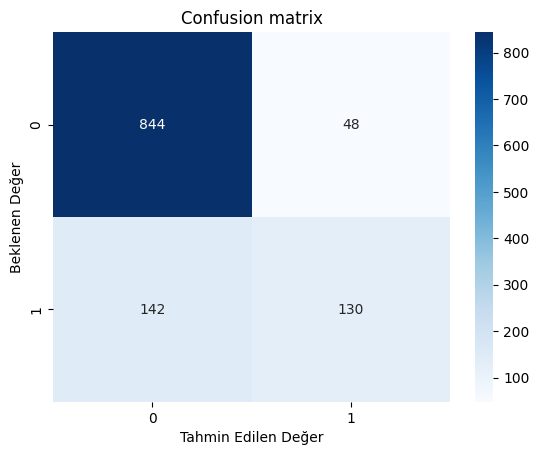

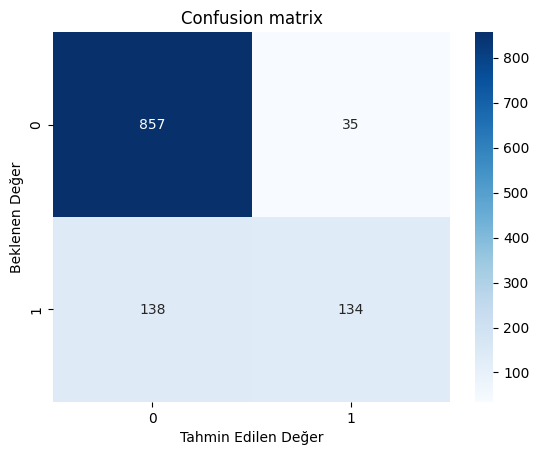

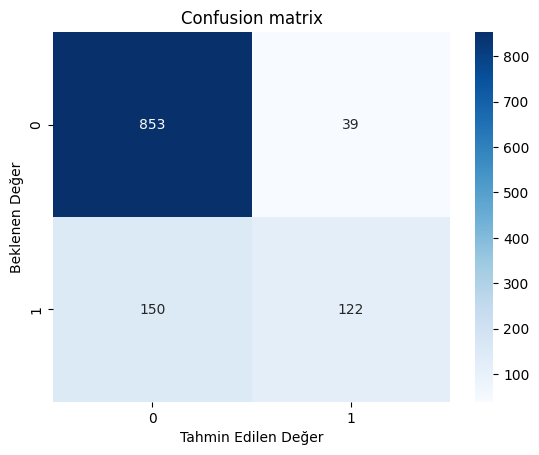

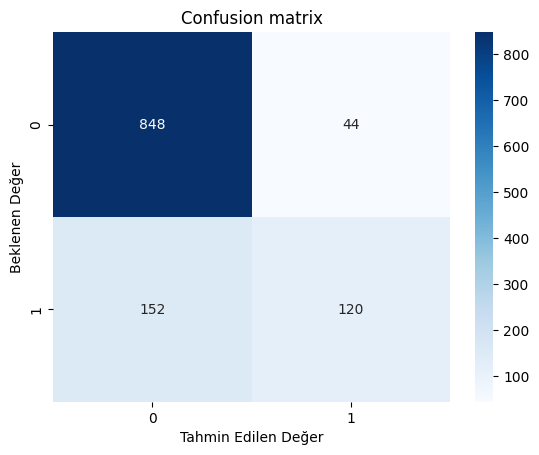

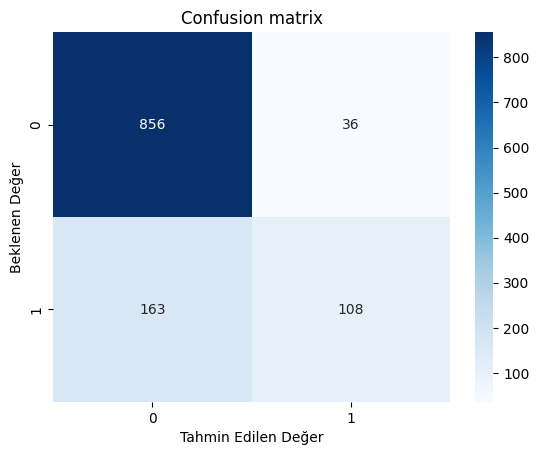

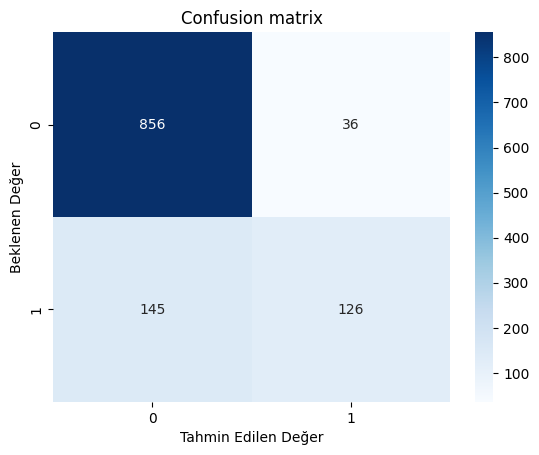

{'fbeta': [0.5964125560538116, 0.5560975609756097, 0.5424528301886793, 0.5929203539823009, 0.5777777777777777, 0.6077097505668935, 0.5635103926096998, 0.5504587155963303, 0.5204819277108435, 0.581986143187067], 'precision': [0.76, 0.8201438848920863, 0.7516339869281046, 0.7444444444444445, 0.7303370786516854, 0.7928994082840237, 0.7577639751552795, 0.7317073170731707, 0.75, 0.7777777777777778], 'recall': [0.4907749077490775, 0.42066420664206644, 0.42435424354243545, 0.49264705882352944, 0.47794117647058826, 0.49264705882352944, 0.4485294117647059, 0.4411764705882353, 0.3985239852398524, 0.46494464944649444], 'accuracy': [0.845360824742268, 0.8436426116838488, 0.8333333333333334, 0.8419243986254296, 0.8367697594501718, 0.8513745704467354, 0.8376288659793815, 0.8316151202749141, 0.8288907996560619, 0.8443680137575237], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), 

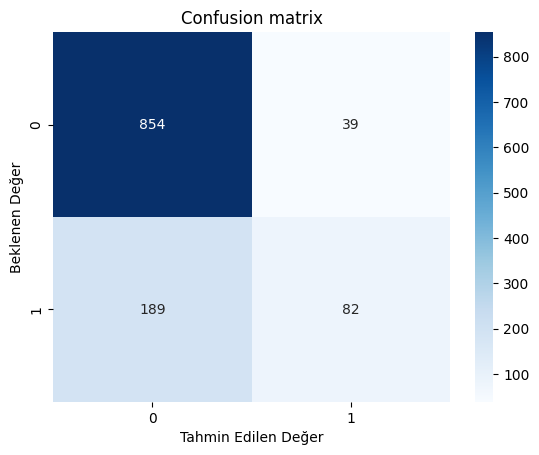

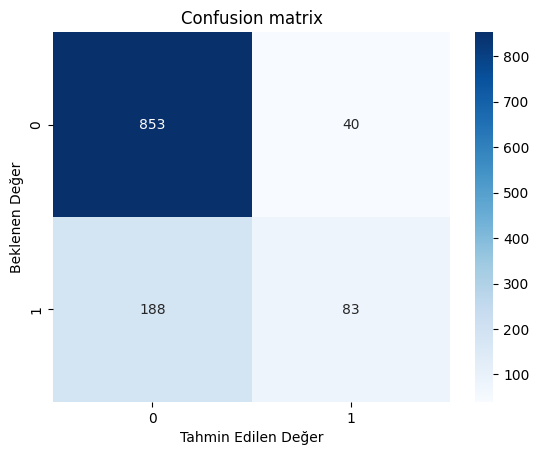

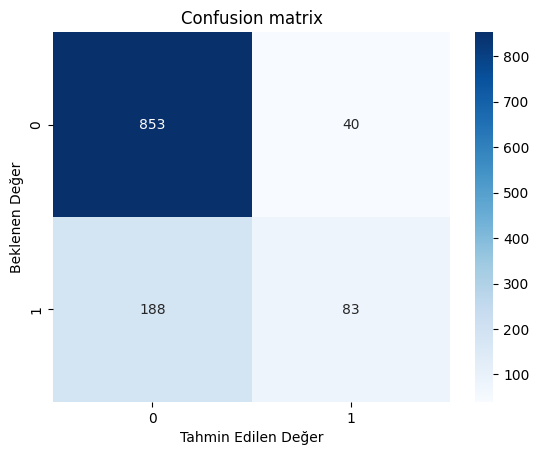

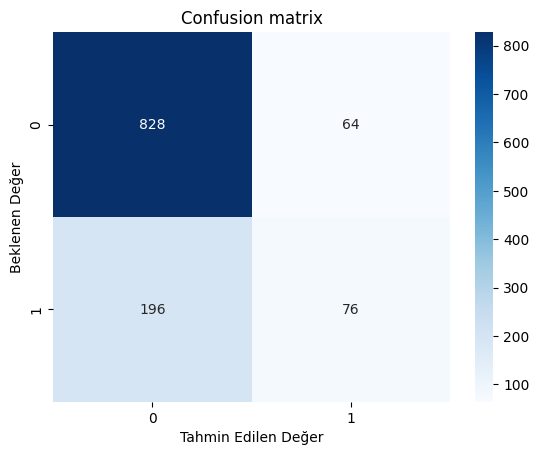

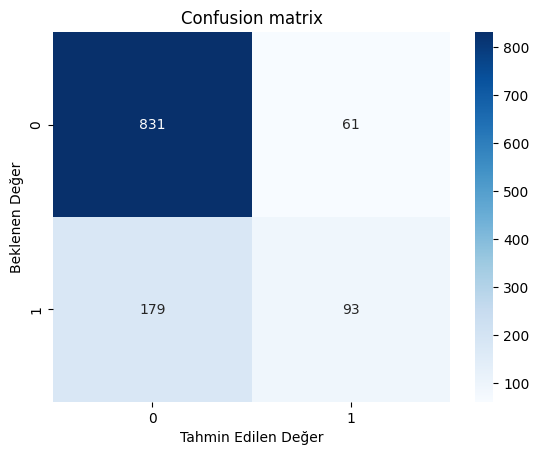

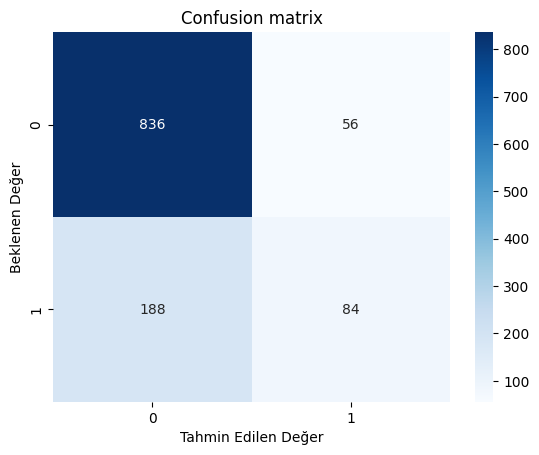

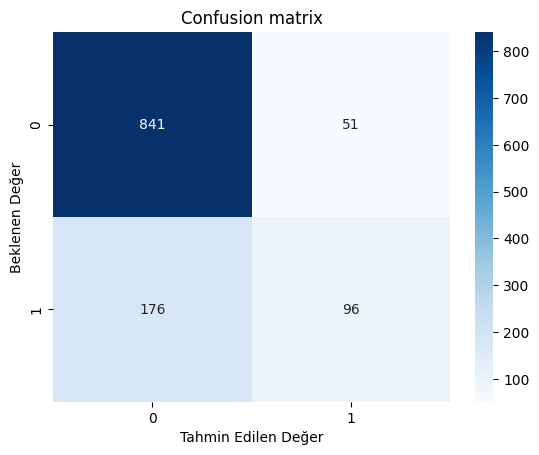

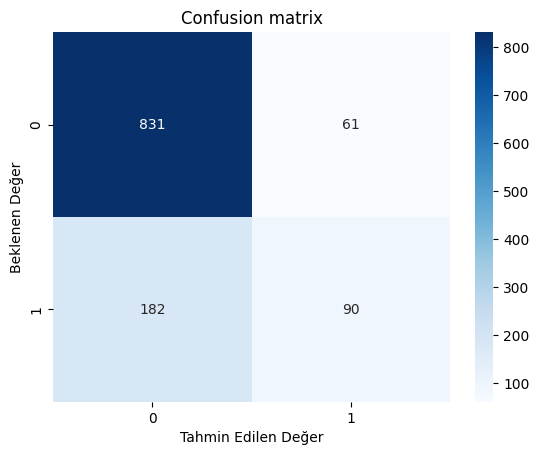

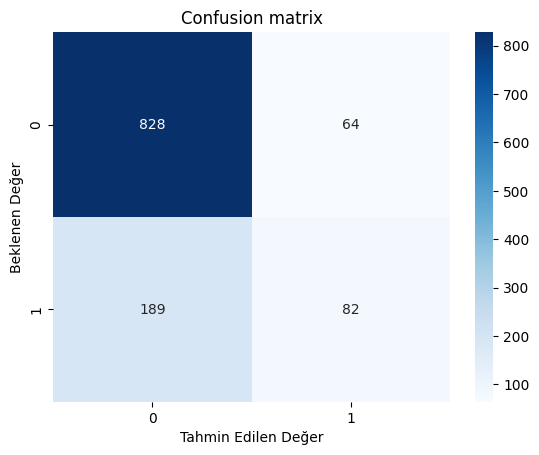

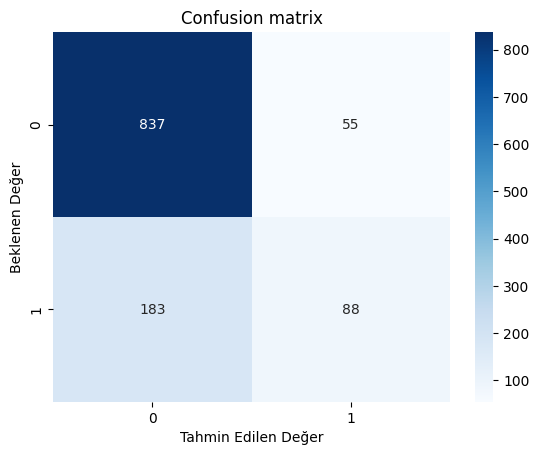

{'fbeta': [0.4183673469387755, 0.4213197969543147, 0.4213197969543147, 0.36893203883495146, 0.4366197183098592, 0.4077669902912622, 0.45823389021479716, 0.42553191489361697, 0.39328537170263794, 0.42512077294685985], 'precision': [0.6776859504132231, 0.6747967479674797, 0.6747967479674797, 0.5428571428571428, 0.6038961038961039, 0.6, 0.6530612244897959, 0.5960264900662252, 0.5616438356164384, 0.6153846153846154], 'recall': [0.3025830258302583, 0.3062730627306273, 0.3062730627306273, 0.27941176470588236, 0.34191176470588236, 0.3088235294117647, 0.35294117647058826, 0.33088235294117646, 0.3025830258302583, 0.3247232472324723], 'accuracy': [0.8041237113402062, 0.8041237113402062, 0.8041237113402062, 0.7766323024054983, 0.7938144329896907, 0.7903780068728522, 0.8049828178694158, 0.7912371134020618, 0.7824591573516767, 0.7953568357695615], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0

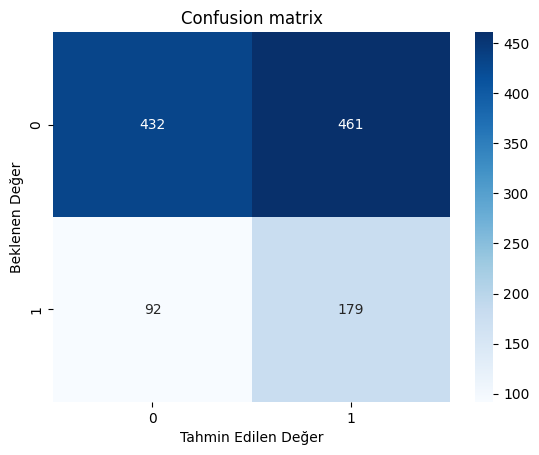

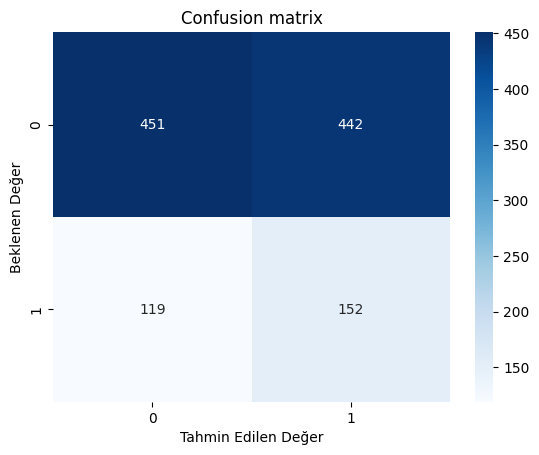

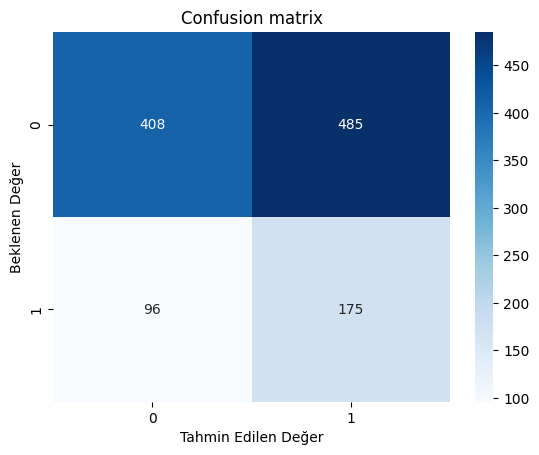

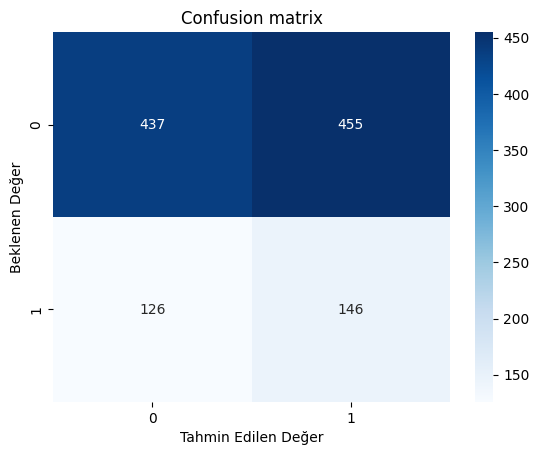

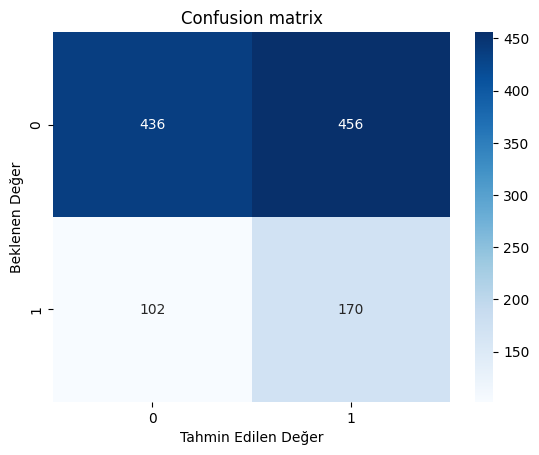

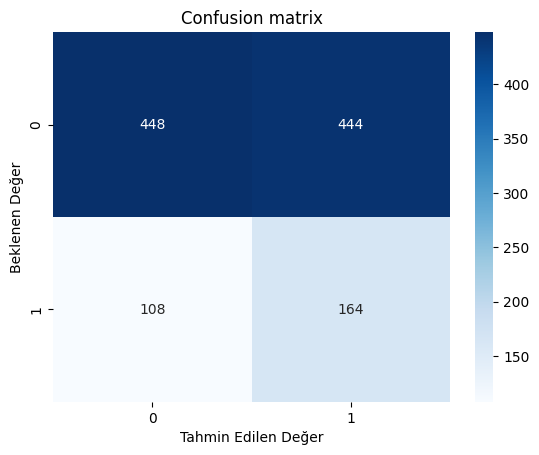

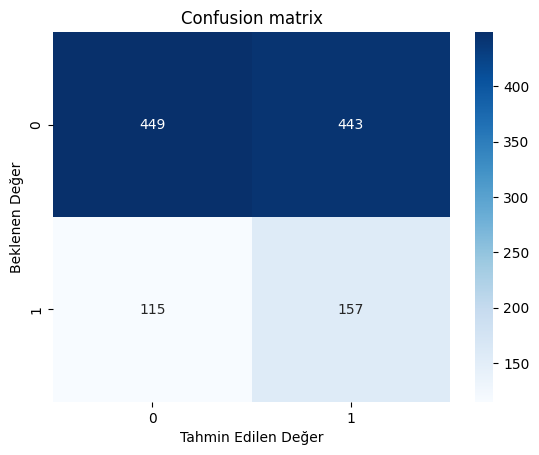

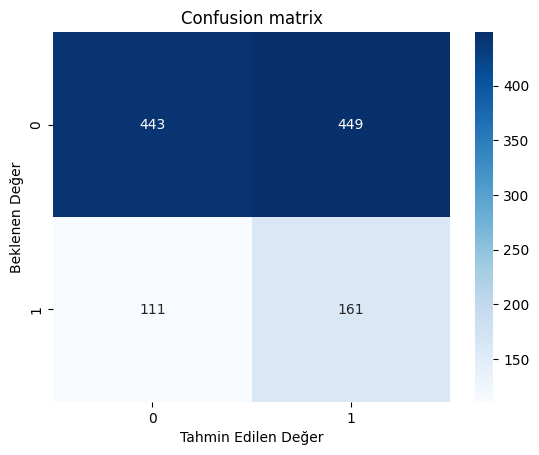

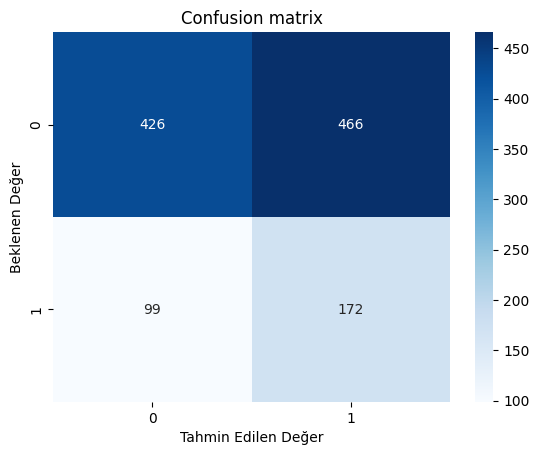

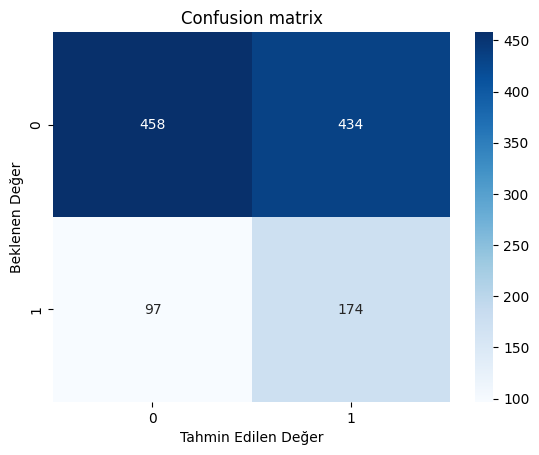

{'fbeta': [0.3929747530186608, 0.3514450867052023, 0.37593984962406013, 0.3344788087056128, 0.3786191536748329, 0.37272727272727274, 0.360091743119266, 0.3650793650793651, 0.3784378437843785, 0.39590443686006827], 'precision': [0.2796875, 0.2558922558922559, 0.26515151515151514, 0.24292845257903495, 0.2715654952076677, 0.26973684210526316, 0.26166666666666666, 0.2639344262295082, 0.26959247648902823, 0.28618421052631576], 'recall': [0.6605166051660517, 0.5608856088560885, 0.6457564575645757, 0.5367647058823529, 0.625, 0.6029411764705882, 0.5772058823529411, 0.5919117647058824, 0.6346863468634686, 0.6420664206642066], 'accuracy': [0.5249140893470791, 0.5180412371134021, 0.5008591065292096, 0.5008591065292096, 0.520618556701031, 0.5257731958762887, 0.520618556701031, 0.5189003436426117, 0.5141874462596733, 0.5434221840068788], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 

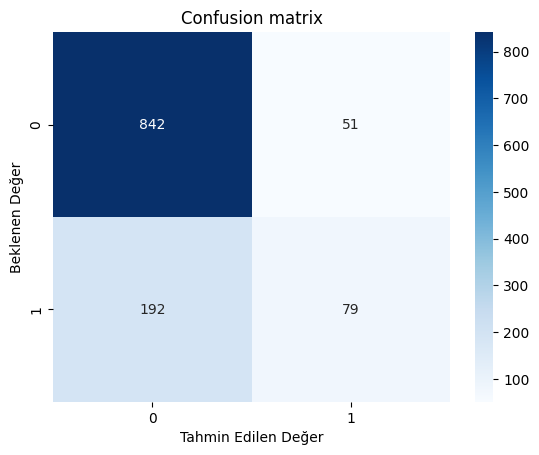

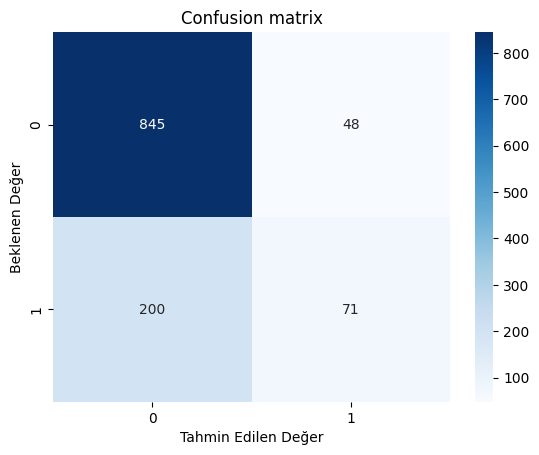

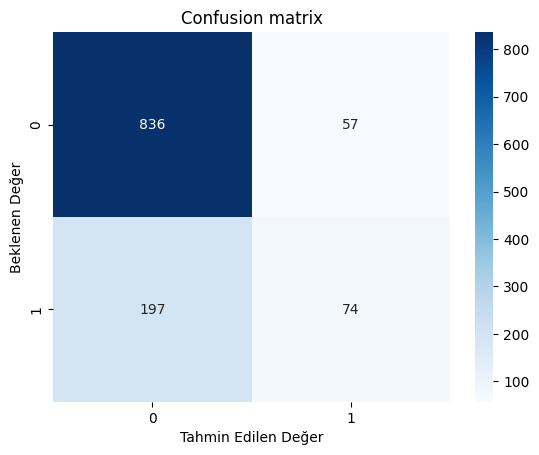

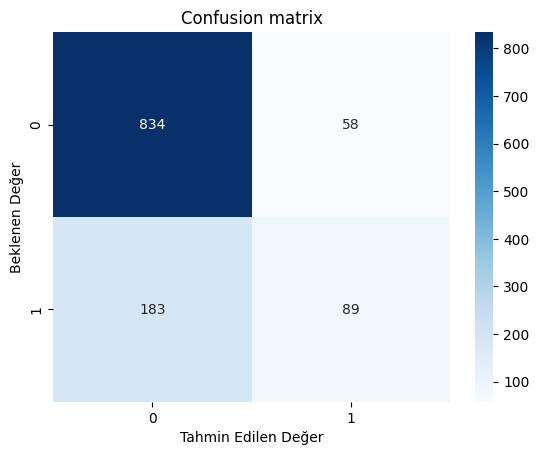

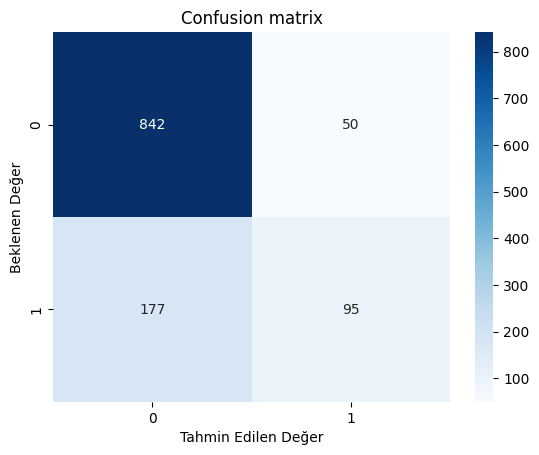

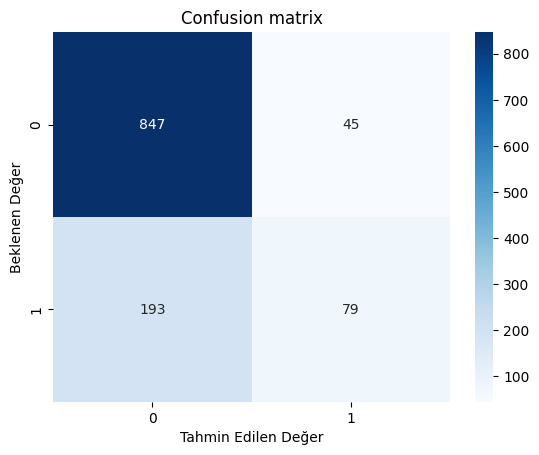

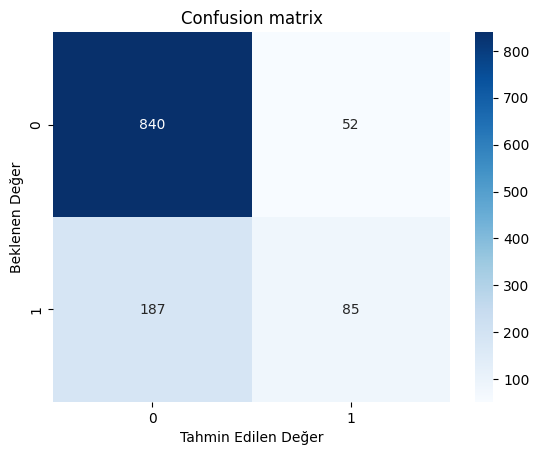

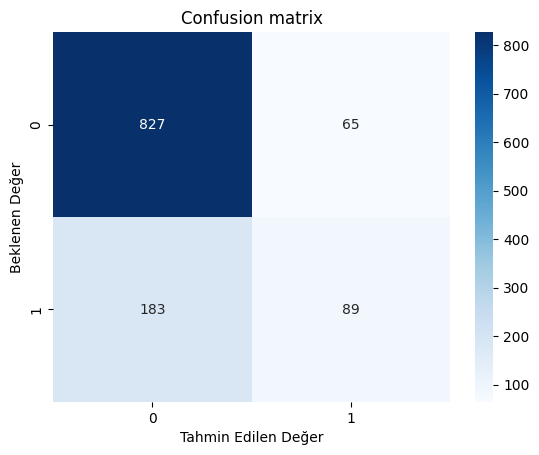

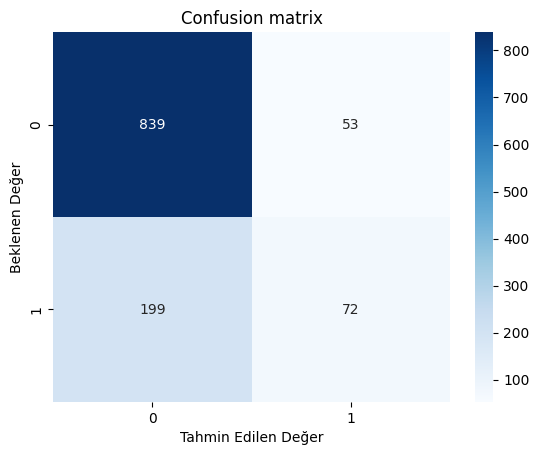

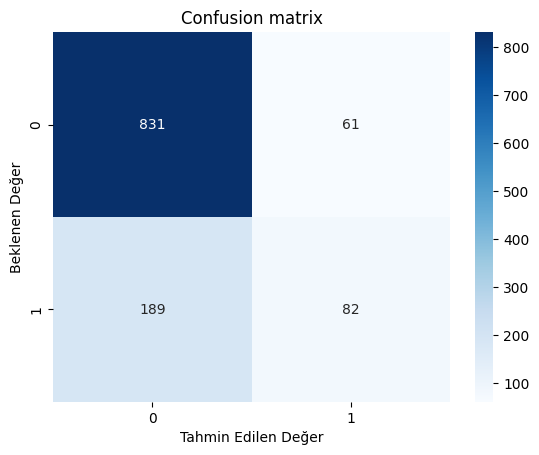

{'fbeta': [0.3940149625935162, 0.36410256410256414, 0.3681592039800995, 0.4248210023866349, 0.4556354916067145, 0.39898989898989906, 0.4156479217603912, 0.4178403755868545, 0.36363636363636365, 0.39613526570048313], 'precision': [0.6076923076923076, 0.5966386554621849, 0.5648854961832062, 0.6054421768707483, 0.6551724137931034, 0.6370967741935484, 0.6204379562043796, 0.577922077922078, 0.576, 0.5734265734265734], 'recall': [0.2915129151291513, 0.26199261992619927, 0.2730627306273063, 0.3272058823529412, 0.3492647058823529, 0.29044117647058826, 0.3125, 0.3272058823529412, 0.2656826568265683, 0.3025830258302583], 'accuracy': [0.7912371134020618, 0.7869415807560137, 0.781786941580756, 0.7929553264604811, 0.8049828178694158, 0.7955326460481099, 0.7946735395189003, 0.7869415807560137, 0.7833190025795357, 0.7850386930352536], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]

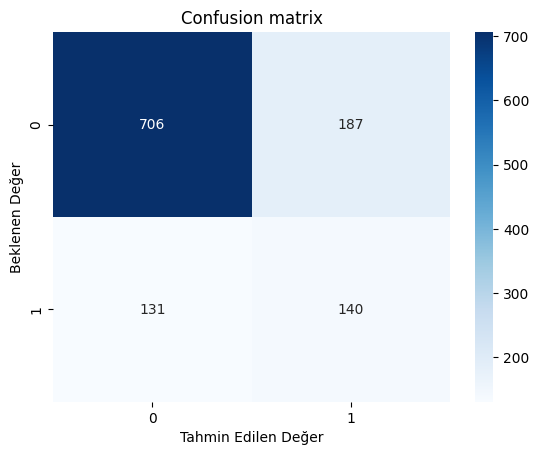

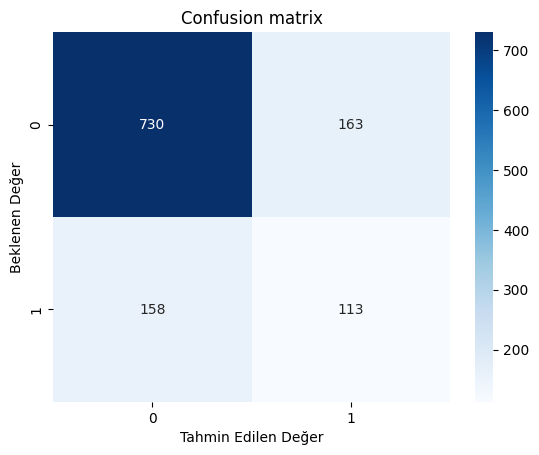

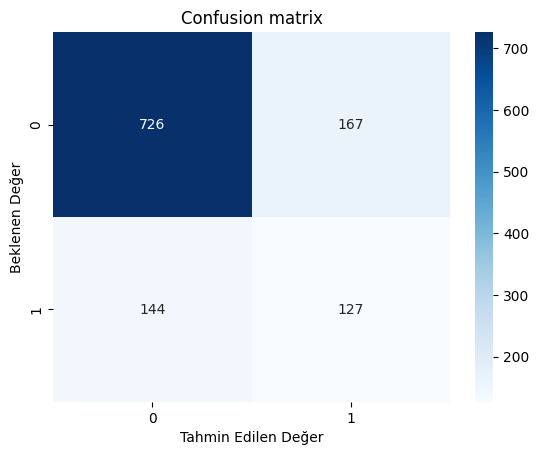

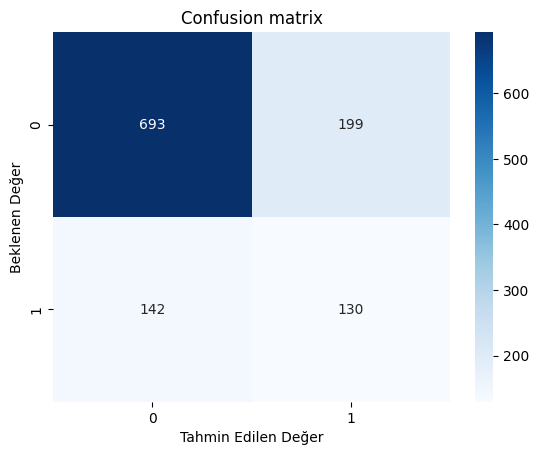

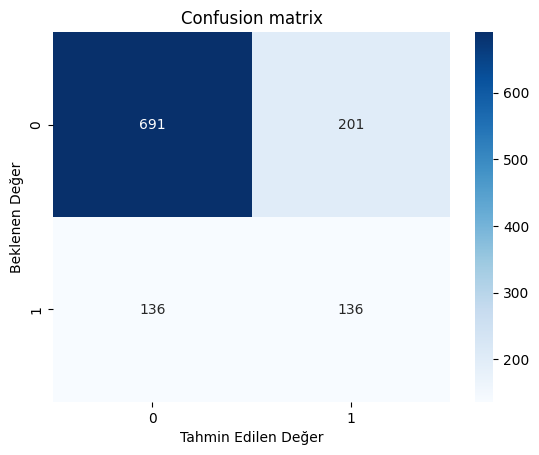

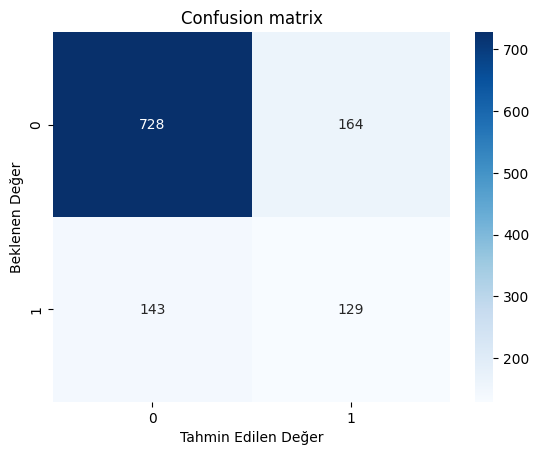

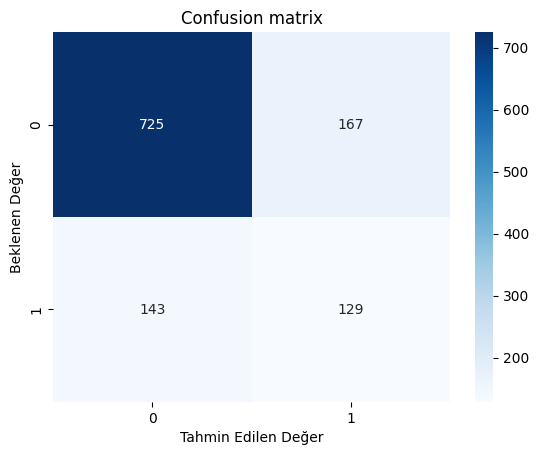

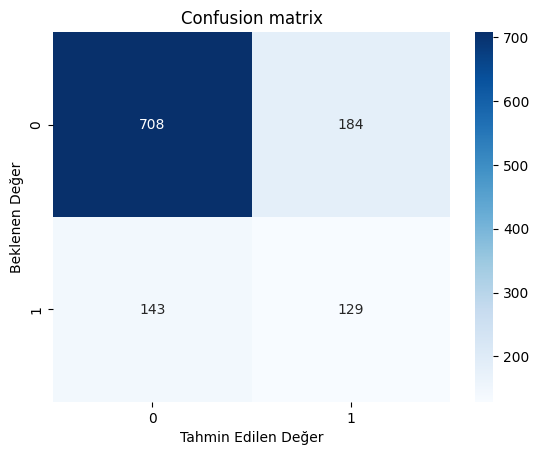

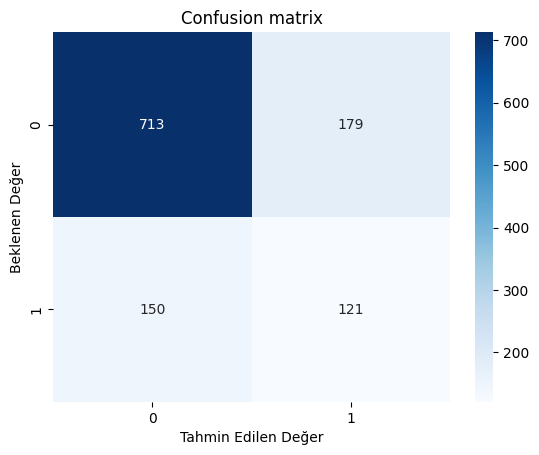

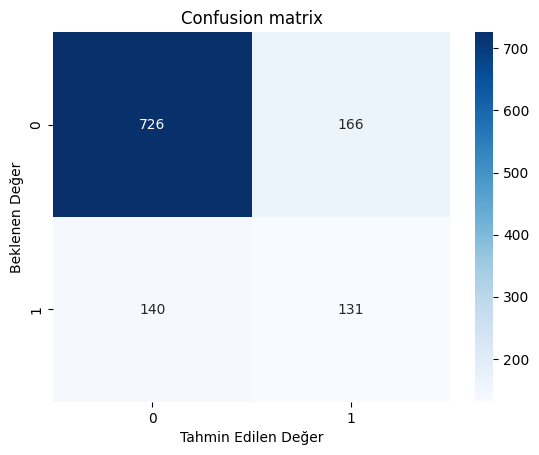

{'fbeta': [0.46822742474916385, 0.4131627056672761, 0.44955752212389377, 0.43261231281198004, 0.4466338259441708, 0.45663716814159294, 0.454225352112676, 0.441025641025641, 0.4238178633975482, 0.4612676056338028], 'precision': [0.42813455657492355, 0.40942028985507245, 0.43197278911564624, 0.3951367781155015, 0.4035608308605341, 0.4402730375426621, 0.4358108108108108, 0.41214057507987223, 0.4033333333333333, 0.44107744107744107], 'recall': [0.5166051660516605, 0.41697416974169743, 0.46863468634686345, 0.47794117647058826, 0.5, 0.4742647058823529, 0.4742647058823529, 0.4742647058823529, 0.44649446494464945, 0.4833948339483395], 'accuracy': [0.7268041237113402, 0.7242268041237113, 0.7328178694158075, 0.7070446735395189, 0.7104810996563574, 0.7362542955326461, 0.7336769759450171, 0.7190721649484536, 0.7171109200343938, 0.7368873602751504], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0,

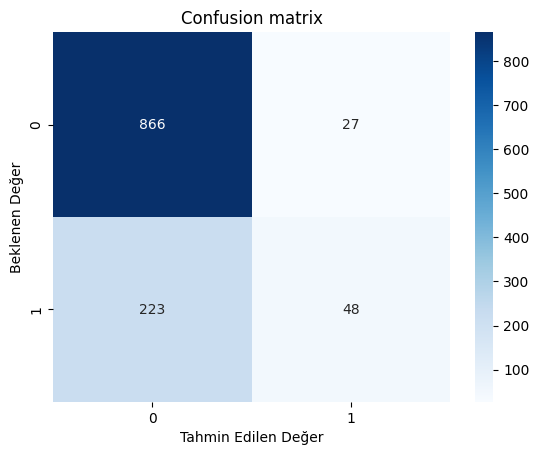

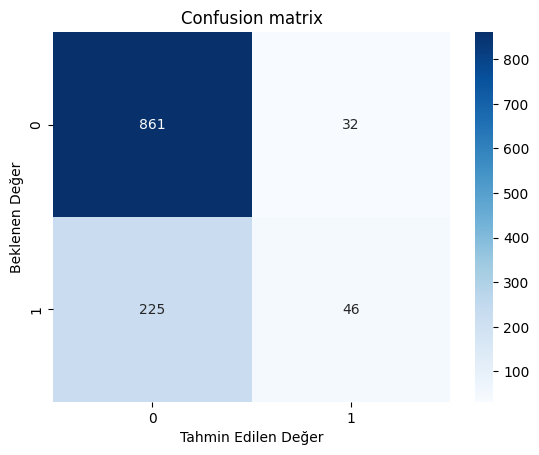

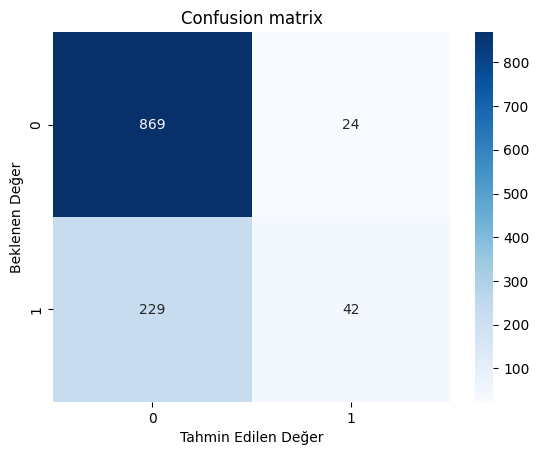

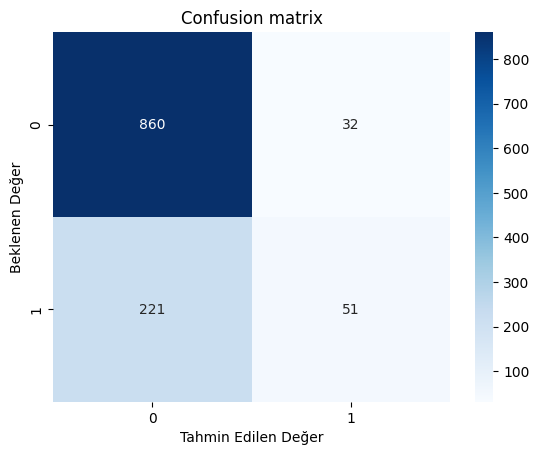

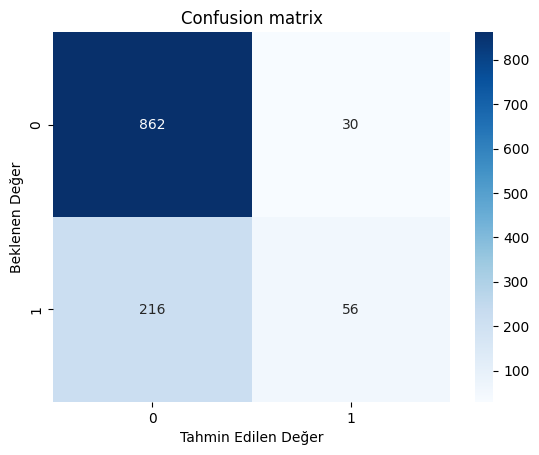

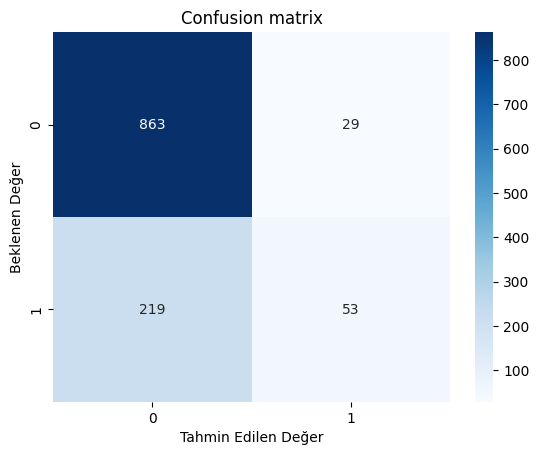

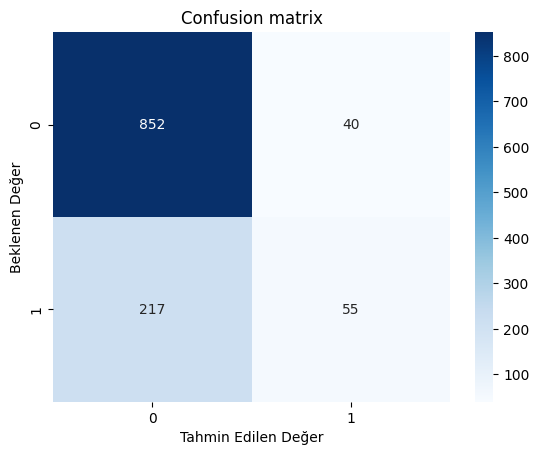

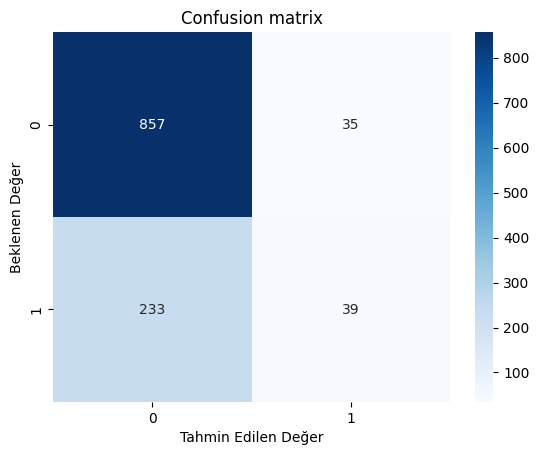

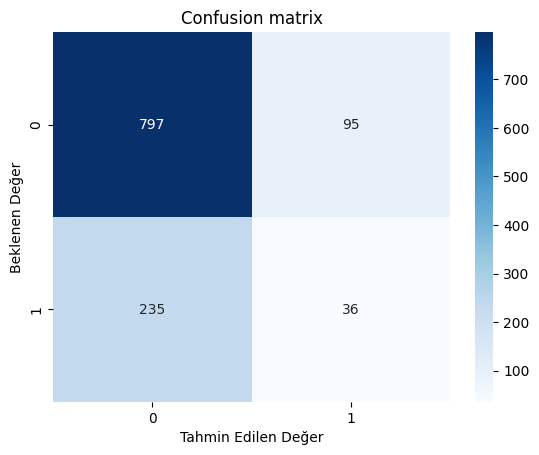

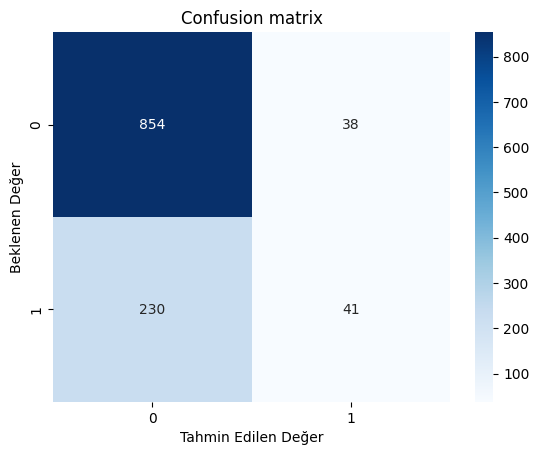

{'fbeta': [0.2774566473988439, 0.2636103151862464, 0.24925816023738873, 0.28732394366197184, 0.3128491620111732, 0.2994350282485876, 0.29972752043596734, 0.2254335260115607, 0.17910447761194032, 0.2342857142857143], 'precision': [0.64, 0.5897435897435898, 0.6363636363636364, 0.6144578313253012, 0.6511627906976745, 0.6463414634146342, 0.5789473684210527, 0.527027027027027, 0.2748091603053435, 0.5189873417721519], 'recall': [0.17712177121771217, 0.16974169741697417, 0.15498154981549817, 0.1875, 0.20588235294117646, 0.1948529411764706, 0.20220588235294118, 0.14338235294117646, 0.13284132841328414, 0.15129151291512916], 'accuracy': [0.7852233676975945, 0.7792096219931272, 0.7826460481099656, 0.7826460481099656, 0.788659793814433, 0.7869415807560137, 0.7792096219931272, 0.7697594501718213, 0.7162510748065348, 0.7695614789337919], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 

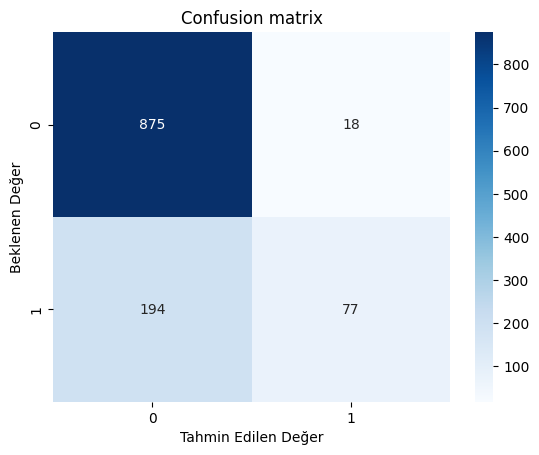

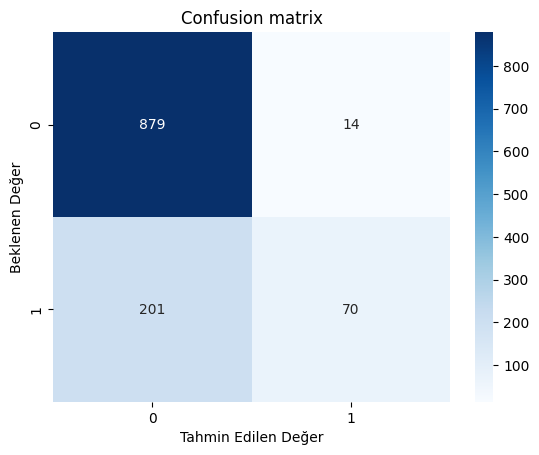

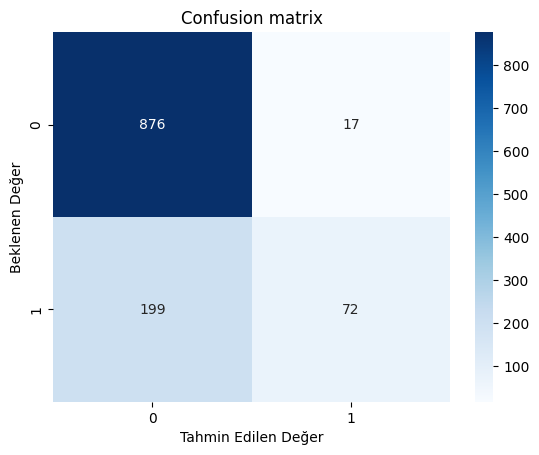

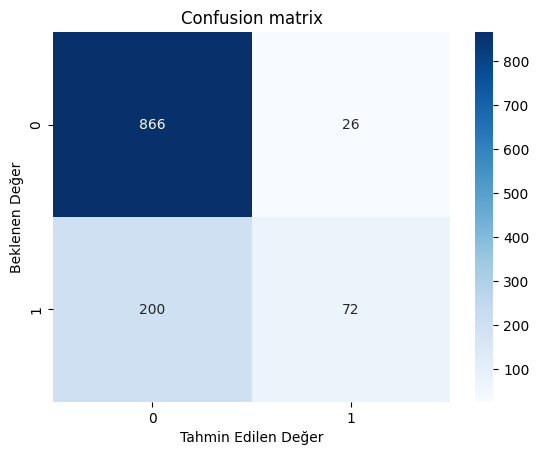

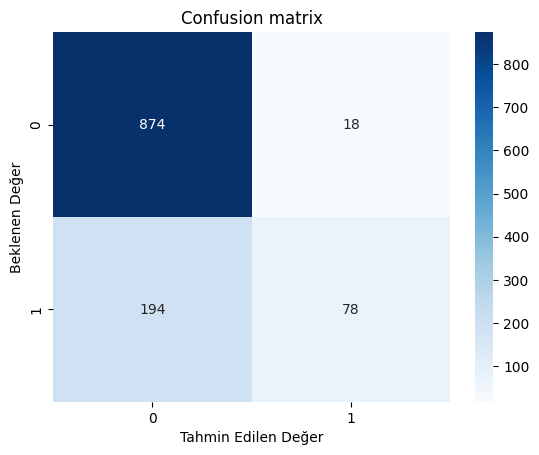

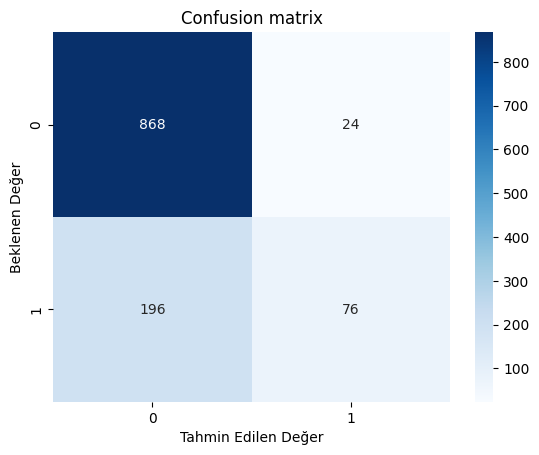

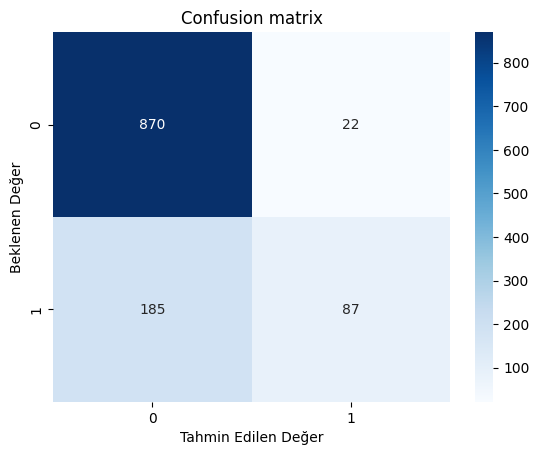

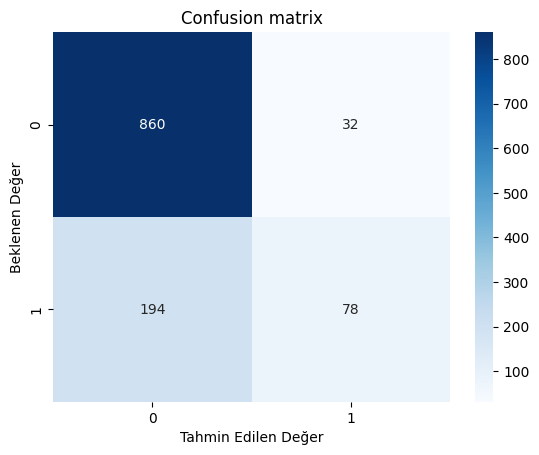

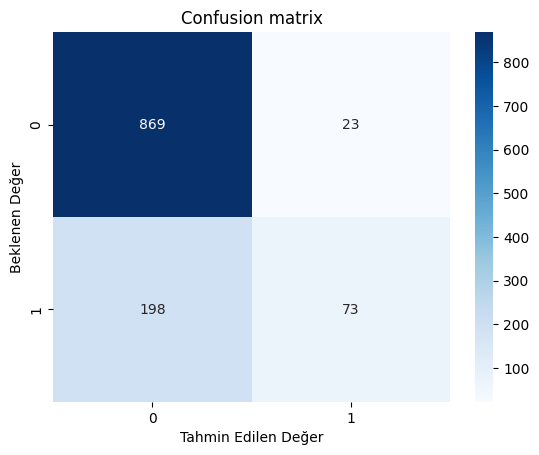

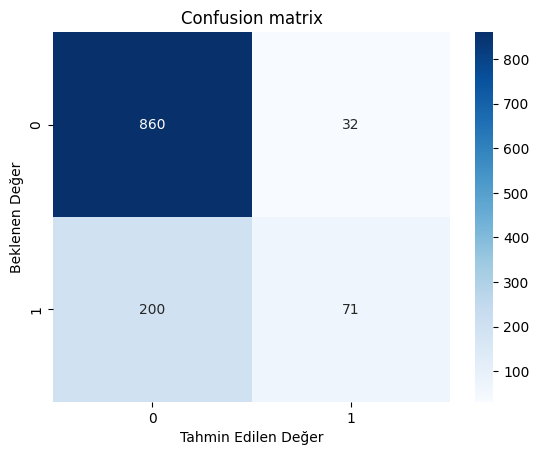

{'fbeta': [0.42076502732240434, 0.3943661971830986, 0.4, 0.38918918918918916, 0.42391304347826086, 0.4086021505376344, 0.4566929133858268, 0.4083769633507853, 0.39782016348773847, 0.37967914438502676], 'precision': [0.8105263157894737, 0.8333333333333334, 0.8089887640449438, 0.7346938775510204, 0.8125, 0.76, 0.7981651376146789, 0.7090909090909091, 0.7604166666666666, 0.6893203883495146], 'recall': [0.28413284132841327, 0.25830258302583026, 0.2656826568265683, 0.2647058823529412, 0.2867647058823529, 0.27941176470588236, 0.31985294117647056, 0.2867647058823529, 0.2693726937269373, 0.26199261992619927], 'accuracy': [0.8178694158075601, 0.8152920962199313, 0.8144329896907216, 0.8058419243986255, 0.8178694158075601, 0.8109965635738832, 0.8221649484536082, 0.8058419243986255, 0.8099742046431643, 0.8005159071367154], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([

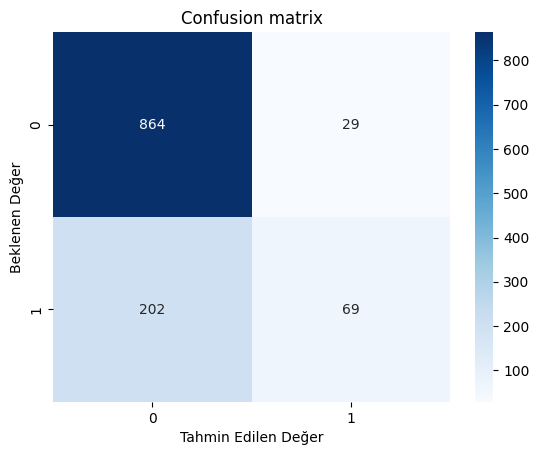

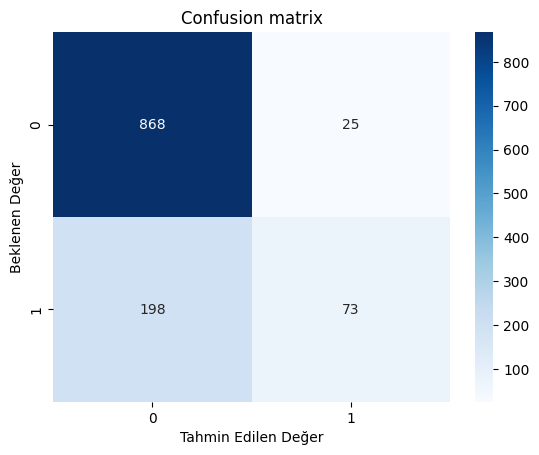

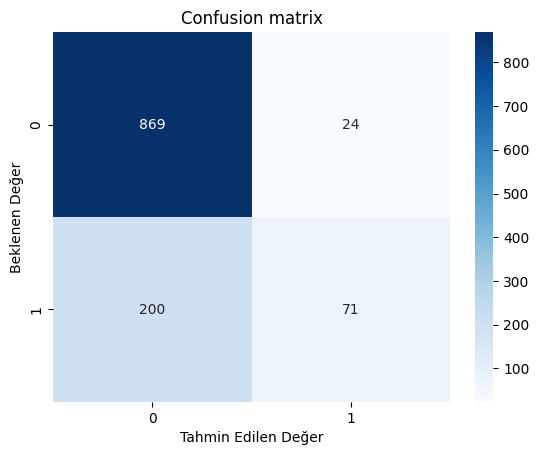

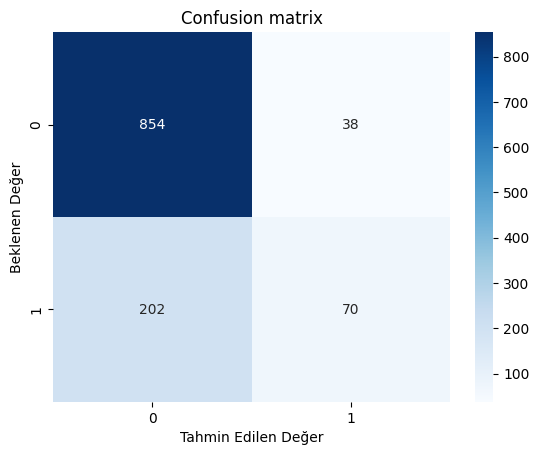

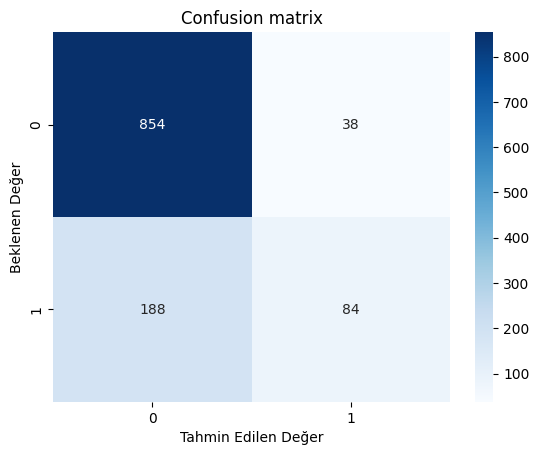

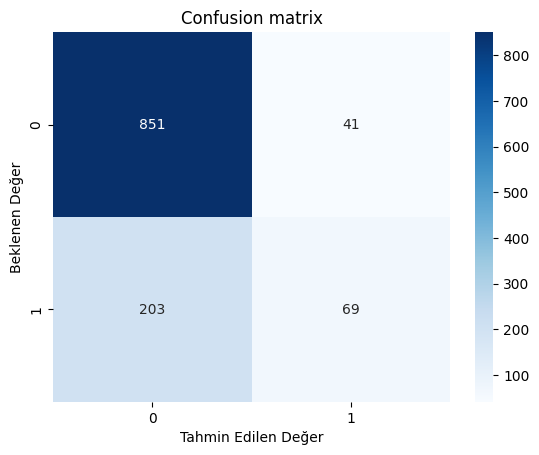

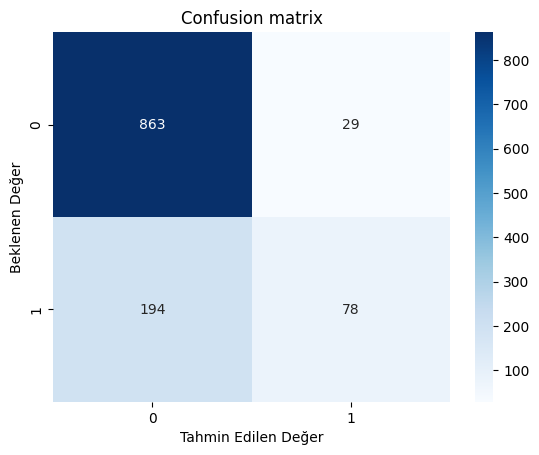

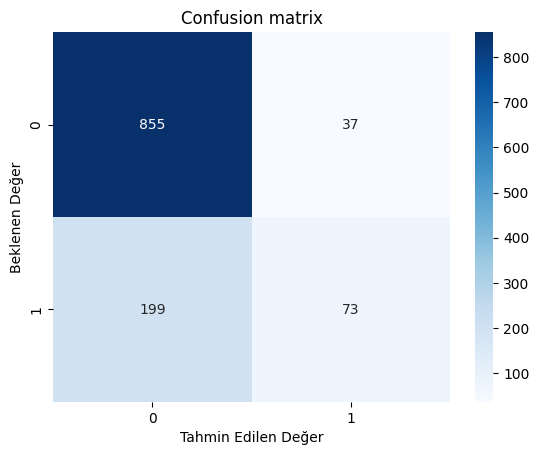

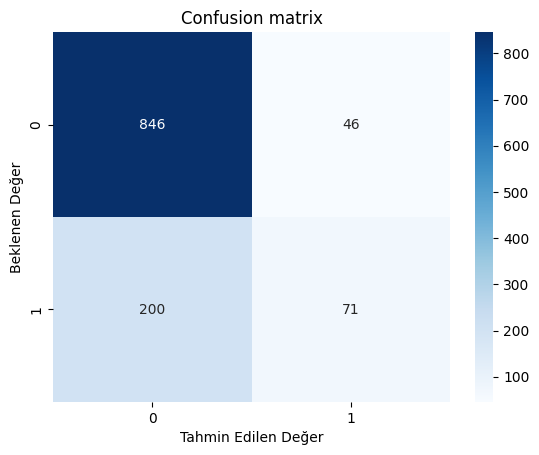

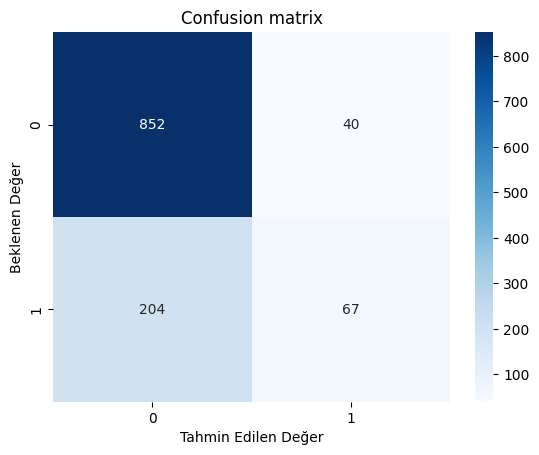

{'fbeta': [0.3739837398373984, 0.3956639566395665, 0.3879781420765028, 0.36842105263157887, 0.4263959390862944, 0.3612565445026178, 0.41160949868073876, 0.38219895287958117, 0.365979381443299, 0.35449735449735453], 'precision': [0.7040816326530612, 0.7448979591836735, 0.7473684210526316, 0.6481481481481481, 0.6885245901639344, 0.6272727272727273, 0.7289719626168224, 0.6636363636363637, 0.6068376068376068, 0.6261682242990654], 'recall': [0.25461254612546125, 0.2693726937269373, 0.26199261992619927, 0.25735294117647056, 0.3088235294117647, 0.2536764705882353, 0.2867647058823529, 0.26838235294117646, 0.26199261992619927, 0.24723247232472326], 'accuracy': [0.8015463917525774, 0.8084192439862543, 0.8075601374570447, 0.7938144329896907, 0.8058419243986255, 0.7903780068728522, 0.8084192439862543, 0.7972508591065293, 0.7884780739466896, 0.7901977644024075], 'y_test': [array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]),

In [16]:
weightingTypes = ['idf', 'chi2', 'or','ig','mi']
#weightingTypes = ['ig','mi']
machineLearningTypes = ["GaussianNB", "LogisticRegression", "RandomForestClassifier"]
result_dic={}
for i in weightingTypes:
    word_vectors, file_classes = my_test(i)
    Y=list(file_classes.values())
    X=word_vectors
    Y=(np.array(Y))
    print(i)
    for m in machineLearningTypes:
        print(m)
        machineLearning(m)
        indexformedian=0
        find_median(k_result_dic)
        a=i+m
        print (a)
        
        result_dic[a]=[k_result_dic[score][indexformedian] for score in k_result_dic.keys()]
        k_result_dic={"fbeta" : [], "precision" : [], "recall" : [], "accuracy" : [], "y_test" : [], "y_pred": []}
        print(result_dic)
        
print(result_dic)
    